## Run Template

In `server.py`, set -
```
add_routes(app, chain_rag_conv, path="/rag-chroma-multi-modal-multi-vector")
```

In [ ]:
from langserve.client import RemoteRunnable

rag_app = RemoteRunnable("http://localhost:8001/rag-chroma-multi-modal-multi-vector")
rag_app.invoke("What is the projected TAM for observability expected for each year through 2026?")

In [19]:
import base64
import io
import os
import uuid
from io import BytesIO
from pathlib import Path

from langchain.chat_models import ChatOllama
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.schema.messages import HumanMessage
from langchain.storage import LocalFileStore
from langchain.vectorstores import Chroma
from PIL import Image

def get_images(img_path):
    """
    Extract images from each page of a PDF document and save as JPEG files.

    :param img_path: A string representing the path to the images.
    """
    # Get image URIs
    pil_images = [
            Image.open(os.path.join(img_path, image_name))
            for image_name in os.listdir(img_path)
            if image_name.endswith(".jpg")
    ]
    return pil_images

rel_doc_path = "docs/"
pil_images = get_images(rel_doc_path)

In [20]:
def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string

    :param base64_string: Base64 string
    :param size: Image size
    :return: Re-sized Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    # img_str = resize_base64_image(img_str, size=(600,460))
    return img_str

images_base_64 = [convert_to_base64(i) for i in pil_images]


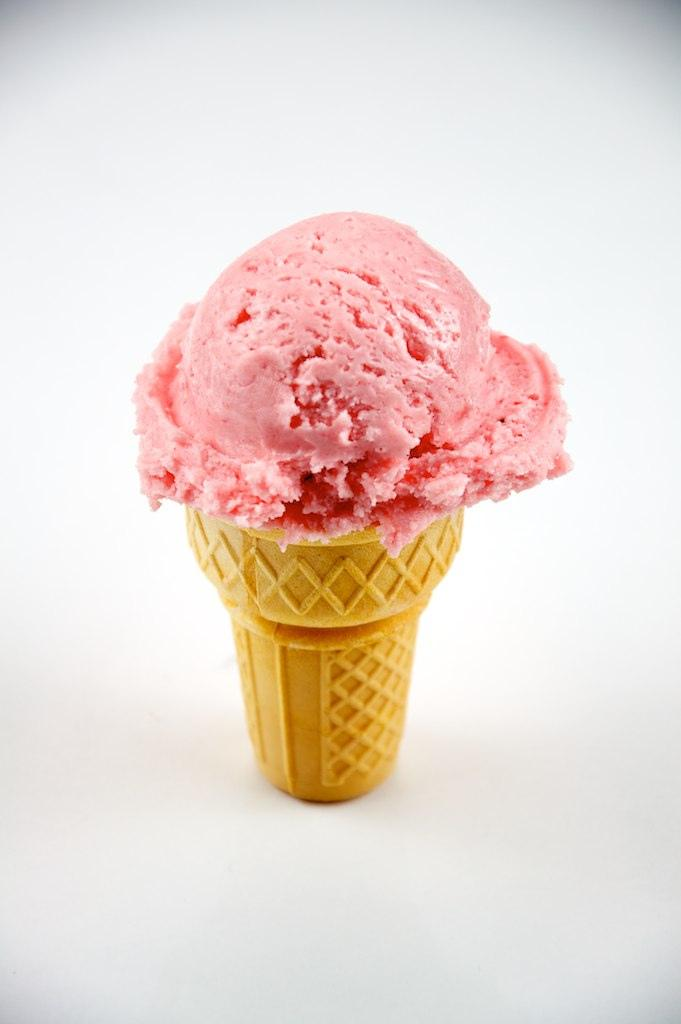

In [35]:
from IPython.display import HTML, display
from PIL import Image
import base64

def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Disply base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

image_base_64 = convert_to_base64(Image.open("/Users/rlm/Desktop/cream_test.jpg"))
plt_img_base64(image_base_64)

In [34]:
from langchain.chat_models import ChatOllama
from langchain_core.messages import HumanMessage

chat_model = ChatOllama(
    model="bakllava"
)

# Call the chat model with both messages and images
content_parts = []
image_part = {
    "type": "image_url",
    "image_url": f"data:image/jpeg;base64,{image_base_64}",
}
text_part = {"type": "text", "text": "What is in this picture?"}

content_parts.append(image_part)
content_parts.append(text_part)
prompt = [HumanMessage(content=content_parts)]
chat_model(prompt)

AIMessage(content='A Picture that has been contributed to by several different people.')

In [30]:
image_base_64

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQAAqkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDYRPapljp6piplT2rQkjVKlVPanrHUoSi4EapUoSnqntUgSgCMJUgSnhfanhKQDQlPCU8JTglAxgWnBaeF9qeF9qBDAtOC08LTttIBgWnBaeFpwWmAzbSgU/bTgtIBm2lAp4FKBQA3bSgU/b7Uu2gBgFKBUmKXbQAwD2oxTwK

In [32]:
curl http://localhost:11434/api/generate -d '{
  "model": "bakllava",
  "prompt":"What is in this picture?",
  "images": ["/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQAAqkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDYRPapljp6piplT2rQkjVKlVPanrHUoSi4EapUoSnqntUgSgCMJUgSnhfanhKQDQlPCU8JTglAxgWnBaeF9qeF9qBDAtOC08LTttIBgWnBaeFpwWmAzbSgU/bTgtIBm2lAp4FKBQA3bSgU/b7Uu2gBgFKBUmKXbQAwD2oxTwKXbQAzFLinbaXFADMUuKdtpdtADMUoFO20uKAGAUuKdilAoAZijFPxRigBm2lxTsUYpANxQBTsUYoAbijFPIoxQMZijFPxSYpiG4oxTqMUgGYoxT8UYoAjxRin4oxTAYRSYp+KMUAR4oIp+KCKAIyKQipMUhFAEZFG2pCKTbQBHtppXNS4o20AQlaTbUpFIRQIi20m3ipCKQigCIimkVMRSEUAQFaaR7VOVppWgCArTStTkU0rQBAUphSrBWmlaBlcp7UwpVkr7Uwr7UwKpX2pjJVor1qMrmgCqyVGY6uMvtUZSgCmY/aomj9qulKjZPagRRZOvFRNH7VeZOtRMntTAoNHVdo+OlaLIPSoXjz2oEZzxcVF5ZrQaP2qLyzTuI31jqVU9qeqe1SqntUl2GKmO1SBKeqe1SBKBkYSnqvtUipTwvtQAwJ7U8JTwvFOC0CGhadtp4WnBaAGBacFp4WnAUANC0u32p4FOAoAZtpdtPApwFIBgFO20/bS7aAGbaUCn7aUCgBu2l207bS4oAbilxTgKXFADNtLin4oxQAzbS4p2KXFIYzbRin4oxTENxRin4oxSGMpcU7FGKBDcUYp2KMUDG4oxTsUUCG4oxTqKAG4oxTqKBjcUYp2KMUANxRinUlADcUYp2KMUCGkUmKfikoGNxSYp+KCKBDMUEU7FGKAGYoxTsUYoAZikIqSkxQAzFJipCKTFAEeKQipMe1IRTAj20m2pSKaRQBEVpu32qYik20AQ7aQipSKaRQIi200rUxFNIoAhK00ipyPamlfagCuVppWpyPamkUBcrlaYVqwVphWmMrstMK+1WCtMZaAK5X2qNlqyy1GUoAqsvtUbLVsp1qNloFYpMntUTJ7VdZOtRMntTEUXSmbatsntTNntQBuKlSBKeqe1SBKRYwJUgSnBaeFoAYFp4WnhacBQIYFp4WnBaeBQAwLTtvtT9tO20AM204LTwKUCkA0ClC04CnAUDG4pdtP20u2gBgFLingUuKAG44pQKcBS4oAaBSgUoFLigBuKXFOooAbilxS4pcUgG4oxTsUUANxS4paAKAsJijFLRQAlFLS4oAbRilooATFGKWigBMUYpaKAExSU7FGKAGkUYp2KSgBMUYpaMUANop2KMUANxRilIoxQAmKQinYoxQA2jFOxRigQ3FJinUYoAbRinUhFADaTFPxSUANIpMU/FJigBmKCKfikIoAjxSEVIRSEUARkU3FSYpMUwI9tNIqUrmkIoAi203bUpFJtoEQkUwrU5FNIoAgIphWrBFMK0DICtMZasFaYVoArstRlaslaYVpgVilRlfSrRWo2WgCqy1Ey1bZajZaBFNkpmyrbLTNlAjZC08LSqtSAUFjQvFPC04CnBaBDQtPC04CnAUANApwFOAp22kA3bTttO20oFADQKdtp22lxQMaBTgKXFOAoAbilApwFKBQAzFLinYpcUgG4paUClxQA0ClxS4oxQAlFLRQAYoxRS0AJRS4ooASilooAMUlLRQAlFLRQAlFLRQAlFLS4oAbRTsUlACUYpaMUAJiilxRigBMUlOxRigBtFLRQAmKMUuKMUANop2KMUANxRinYpKAExSU7FJQAmKMUtGKAG0Yp2KSgQmKTFOpKAG4pMU8iigBhFJin0mKAGYpMU/FJigBhFIRUhFIRQBFikIqTFJj2pgREUm2pSKbigRFtppFTbaaRQBCRTGWpyKaRQBXK0xlqwRTCtAyuy1Gy1ZK0xloArMtRslWWWmFfamIqstM21YZc0m2gRqgU8ClC08LQUIBTgtKFp4FIY0CngUoFO20CG4p2KcBS4oAQClxTgKUCgYgFKBS4pcUAIBS4pQKXFACAUtLijFIBKKWigAxRiiigAxRilxRQAgFFLRQAYoxS4oxQAmKMUuKMUAJiilxRQAlFLijFACUYpcUYoATFGKXFGKAEopaKAEopaKAExRS0YoASilxRigBMUYpcUYoAbRTsUlACUUuKMUAJRiig0AJRS4oxQAlIRTsUlACUYpcUYoATFBFLijFADaMUtFACYpKdikoEJikIp1GKAGUU4ikxQA0ikIp9IRQAzFJTyKTFADCKQinkUhFAEZFNxUpFNxTAj20wrUxFNIoAhK00ipiKZigCErTCtTkZphWgCAio2WrDLTCtAiuUpmyrDLTce1MDTC07bSgU7FIoQCnAUoFOAoAQCnAUYp2KAEApwFLinAUANxTgKUClxQAgFAFLS0gEAopaKAEopaKADFFFLigBKKWigAoopcUAJRS4ooASilooASlxRRQAYoxRRQAYoxRRQAYoxRRQAYoxS4oxQAmKMUuKSgBKXFFFABijFFFABijFFFACUUtFACUUpFGKAEoxS4pKAEoxS0YoATFJTsUYoAbRilxRigBAKMUuKSgBKKWjFACYpKdikoASilxRigBMUYpcUlAgxSUtGKBiUhFLRQIbikIp9JigBmKCKcRRQBHikxUhFNxQAwjimkVJim4pgRkUwj2qYimkUAQlaaRUxFMIoAhK0wrU5FMIoEQFaTFSlabj2oEaIWngUoHFOAoLG4pcU7FKBQAlKBS4pwFAABS0AUtIAxRiilFACUUuKKAAUUUYoAMUUUUAFFLijFACUuKKKACilxR0oASlxQKOtABSUtHegAxRiiigAxRiilxQAlFLijFACUUtFABijFFFABikpaKAEopaKAEopaMUAJRSgUUAJRS0UAJijFLSEUAJRS0UAJRilxQaAExSYpxpKAEIoxS4pKADFJS0UAJRS0YoASjFLikoASgilooASkp2KSgQlJTsUhFACEUYpaMUAJikpaKAExSU6koAaRSEU+koAYRSU8ikIoAjIpCKkIpuKAIyKaRUpFNIpgQkUwipitNIpCICKTFSkYpuKYGhinYoxTgKCgpQKAKdSAbilApaMUAFLSUooAKKKKACiiigAopcUYoAMUUUUAFLijFFABiiiigAopcUUAJRS0UAJS4opcUAJiilxRigBKKUUUAJRS4oxQAlFLRigBKXFFFABijFFFABijFFFABRiiigAoxRRQAYoxRiigBKKWjFACYpKWigBKKWjFACUUuKMUAJSU7FIRQITHNFLijFAxCKMUUUCEopaMUAJRRRQAGkpaMUAJikpaKAExRilxRigBtGKWjFACYpCKWigBMUlOpKAEpCKdSEUANppFPIpCKAGEU0ipKaRQBHimkVKRTSKYEJHWkxUhHFJigRdxTgKAKdSKEApQKWjFACUUuKKAEopaMUAJS0YooAKMUtFACUuKKXFACUUtFABRiiigAopcUUAGKKKKACilxRQAlFLRQAlLiiigAxRiiigAxSUtFACUUvSigBKXpSYpaADFFFL0oASilxSUAGKKKKAEopcUUAAo60UUAFJS0daAEoopcUAJikp1JQAlFLRQAmKMUtJQIMUlLRigBMUlOxRimA2ilIoxSASjFLijFACdqSlooASjFLikoAKSlooATFJTsUlACUYpaKAENJS0YoATFJS0UDExSUtGKBDabinkUhFADMU3FSEUhFAERHFJj2qQim4oEXMUtGKKCgopcUUAGKMUUUAGKMUUUAGKKKKACiiigBRRRS4pgJS0UuKQCUUuKMUAJRS0UAJS4opcUAJS0YooAKKKKACiiigAooooAKSlooASiloNACUtFFABRRRQAUUUUAFGKKKACjFFFABiiiigBKKWjFACUUtJQAYoxRRQAdKSlooEJRS0UAJikpaKAEopaSgAxRRRQAYpKWg0AJRiiigAxSUtGOaAEpKWigBKKXFJQAYpKWigBKMUtJQAhFFLRigBtGKWjFADSKCKWigY2mkU8ikIoEMpMU4ijFAFmiiloGJS4oooAMUUUvagBMUUuKMUAJRS4oxQAmKKKKAFFFAooAXFFAooAKKWjFABijFFFABRRRQAUuKMUUAFGKKKAA0lLRQAlFLijFABSUtGKAEopSKMUAJRS0UAJS4oooAMUdKKKADtRRRQAYoxRRQAYopcUYoATFGKKKAEopcUYoASjFFFABSUtFACUUtFACUYpcUlACUUtBFACYoxRRQISiloxQAlGKKKAEopaMUAJRilxSUAJRS0UAJRiloxQA2ilooATFJS0YoASilxSUAJRiloxQMaRSEU4iigQzFGPenUlAE9FFLigYUUUUAHSiiigAopcUYoASilooASilooASiloxQACiilxQAUUUuKAEopaKADFHSiigAopcUUAGKMUUUAHeiiigBKXpRRQAYoxRRQAYoxRRQAYoxRRQAUUUUAGKKWjFACUd6KKACjFLikoAKKKXFACUYpcUYoASjFFGKAEopaKAExRiiigBKKWjFACUUtFACYoxRRQAlGKWjFAhMUlLQRQAlGKXFFACYpKWigBKKWjFACUUuKMUAJijFFFACUYpaMUANoxS0UAJijFLig0ANoxS0lACUUtJQAlGKWjFAEuKKKKBhRS4ooAKOtFFAAKKKUUAJRS0UAGKMUUUAAFLiiigAxSUtFACUvSiigApcUYooAMUUUtACUUtFABijFFFABSUtFABijFFFACUuKKKAEpcUUUAApKWigBKKWigAxRRRQAYooooAKKKKACiiigAooooADSUtFACUUtFACUUuKMUAJijFLSUAJRS0UAJRil70lAg7UYpcUlACUYpetGKAExSUtFACUYpaKAExRiiigBKKWigBKKXFGKAExSUtFACUUUUAJRSmkoASjrS0lACUUtBoAaRRS0fjQBKKKKWgYlFLRQAYooooAKKXFGKAEpaKKYB1ooooAKWjpRSAKKKAKACilooASilooASlFFFABRRRQAUuKBRQAYoxRRQAYoxRRQAYpKWigAxRiiigAxRiiigAxSUpwBkkY9TVeW8jTIX5yPSk2kVGEpbFjFJ068D3NZkmoO3yghD6AVXaQyDJZj9e9Q6h0RwsnuarXcKtgt+IqJ9ShU4AYn6Vlk89eKQHAx+tRzs3WFgtzS/tHPSP8AM0v9oHH+qP51QQr/ABGoZZLp2XygioD3PNHOxrDwfQ0l1Eg/Mgx6CpV1CI9VYZ6Cs+QFgD0bvioVZw2MY96Odh9XgzcW5ib+LHseKkV1YZDA/SsHeQdpYZ9KcJGUjk4pqozOWEXRm7RWUl9LGOeV9+auQ3qOMOQrHoDVqa6nPOhOJZooBBGQQfoaWrMWrCUUuKQigANBoooASilxRQAYoxRRQAlFL2pKAEopaDQISjFFFACUUtGKAEpKWigBKKXFJQAUUUGgAPWkoooAKSloNACUUUUAJRS5pKAA0lKaSgANJS0YoAlooooGLRRRQAUUUUAFFFLigBKKWimAYooopAFFKKKACiiloASil60YoAMUYoooAMUlLRQAYoxS4oxQAlFFLigBKKXFFABSUtFABikpaKAEoo6VWmvETKphj+lJuxUYOWxYJCjJIA9TVWS/RchBuPvxVOWaSU5YnHoKj471m59Drhh0tZDpbmSU/M2B6ZqAuynofrUjLhSQM1CrFwCkbcnnd2rN3OqKSWg9ctyRTJCcgZAz61ONqybc1i67JLp+26jR5FDDcMZ2g8ZpPRXNKa558pqHAzzyB0oCnGTUVtFIp812zuA4x0qaRh1PbvQD0dkGDwMZ5pH3gDacEfrSxSxuqsrA7hke9OZwuKCdbiru8sbsbvamO4PBXk0rSKcZfH0qEnc5A+72z3oBIWQcZCbs0nnAHaVY/QUKdowT+NIxLc7jxQWkKWbGQD9MUvmA89KYdwXqSfU1DPGWXgmgainoXBcyQ9ScdiprQtb/AHAb2BGetYSyKy+UzZ56jrmpUjaN9ytx3B701KxlUoRktTqFZXUMpyD0Ipap2N0kkaoThgMYNXK3TueTOLi7MMUGiiqJEope9GKAEooooEFHalxSUAFJS0YoATFJS0UAJRS4oxQAmKMUUUAJRS0YoATFJS0UAJSUpFFACUUtJQAlFLRQAlJS0UAJRS4pKAEopcUUASUuKMUUDCiiigAoopcUAJSiiigAooooAKXFAooAKKKKAFxRQOlFABRRS4oASilooAMUUUUAFFFLigBKKXFGKAEopaMUAJRRRQAUySVIlJdgBUNxeLENq8t39qzJJTISS2fes5TS0OilQctWT3V4ZBtXhfQd6pndu649RQG25A596d8sq4PGfSsm7nfGCgtBGk+bqPb2pVwTnOargbSQ3Udc1Kudvt60i2kloSFgD060xZ8sQFP1NQNdxAkKckdcULc5OAlK41Tdti+skaRM79MdTWZb6rHcxsvB+Y4yPSrZbehVwMGqc2mW/wBn2wZifHBB60Sv0CmoK/OXYJkmGMjPSkmtw67dxHNU9JtJYbc/aCRJu6g9u1aWAetNXa1JlaM3ysreWqAbVGQODQrhjj+VTMvOAM+vNN2eWNwoGnoN8oBjkVH5gEmwqRnoTU+8SIe3aooFdkxLgnPUd6AT7jzECeaY0YU8flUhyCMcjODSSK3PPFMEyPtyKaCCSP0pIHeaZ0MZCqPvetSbQrYA5zSKvbQZ5SsxbaN2MZqC3jljLLJJn+6TVo5H1qM4LAjJYdqBp6Cl3iIZQMjsK1LLUhKoV+vrnpWUx3Hoc+5quwaJt6EgjmmpWMqlGNRanXjBGQRz0IorDstSbgHkY5BNbEM6TDKnkdQa2jO55tShKDJcUlLRVmIlGKKKAA0lLRigQlFFFABRiiigBKKU0lABikpaSgAooooADSUtFACUYoooASjFLijFACYpKWjFACUYoooASjFLijFACYpKWjFAElAFLRQMMUhFLRQAUUUUAFFFFABS4oooAKXFJS0AGKMUUuKAEpcUUGgAooooAKKKWgBKKXFFABiiiigAooooAKKKCQoyTwBkmkG4h4GTwPWs+6vB91CeO4pt3dmQ7E4FZzOeecn1rKczuoYf7UhlxdCIHPLHoKYryypvIA44BqncoQryZJcdBWbHd6gUDMmxR78e1YOTPVhQUo6G6sjBdpxn0Hao453+0FCDx6U6wUyWaSyriRh8wp8jqjByME8dOTVW6meibVieB1kndSckcAVV1W7mspY4FjLmXuB2HWrESqtx54ADkcmnyOHbLgEg091YzVlO9roqRWyiPeVwp74pGZAxj3/rV1mLRlB0PSqsNmsUzzSMHY9MjpSsWp3u5E0ZZUwaiWba53owX1xxVjcM0djuAK0yLiGYLj09qeJM1WAnJyq7hn7tLIs6yLshHPct0oBxRZGfwpNxBxWPdald20jo9tKcdwuQaLPV4rhgrsMeoOannXU0+rz5ebdGxtyvTj2qMgqR82Oe1JLdRxqNpyOO9V5P38qmOQBh1FU2jOMX1LPm4PPBolkyueuKg8zE3lurD0OOtTMpB6HGKB2SYRzDjjimXCmVfkcq2c5pGQD5uSPQVFBcCUFkyyhtpNA1HqhwDpcIw5BOHU1MyqvIHWmM2WyKXaZEK78HtzQD7kcxwDkVBDcBwcKTzyGFXzaOV45NVJIGifJGMHqaLMqMotWG/ICHjJRvQ9KvW1xIrEbSpxwwqky7Wzzj26VFHLIjFQx2k9+1F2mTOCkjqbS9W4zGw2yr1B/pVuuaR2AEqH5+x6Vs2d8s/wC7Z180DoK2jPozzK+HcdYlykpaMVocolFLQaAEo/ClxSEUAJRS0lAgpKWg0AJRRRQAYpKWigBKKKKACkpcUYoASiiigApKWigBKTHFLRQAlFKaSgAxR+VFH40ASUUUUDCiiigAopaBQAYoxRRQAUUoooAKKKKAClFGKKACiiigAopaKACiiigAoopetABRRRQAGkpaKADtWbe3G9hGjcA8mpru6CZjQ/N3I7VkSuUPBJJHArKcux2YejrzMa7jcRnrSKM8mmrE5B7epp7KQCCcVkd+i2G4G7Hr2pskSSDBAI708lQBhvoacBxnjFFgv1IjGSgG4gDuOKUbTgEE++Ks4XAx+NRu209KBc1xpRY1DyNwBVK41i1jQlQTjgmrhEcg2yDIqFobYMSsSg+uKTV9i4ct/eIrTURdxeasL7fUjrVlJvNcpsYcdxSJ+6i2gAD2pyueM9fagJWd7Ia8ZT94ZMKvXmkW6jLBN4yfU029t3ubdok4D9WFZ2oaU6WO61kLXEY4B4pSv0LpqErKTNsShT7+1O8xWI3Hp0NU7RpZbGN5xtkIG4YrLmj1C3vZJElM1u5+VCOU/Gm5O1yI0lKTVzpXkDY24PqDVOTTrGWUyNApYjBP0Of51m6Xqkd47xZIkQ4I71qklaakpImVOVKVr2KOp6bJ5Ik07AdeTCf4/wAe1ctNqt6moyfuPJaIYaMnn2rukkXdUN5YWl/GyyxqHK4EgHzDNTOHNsb0MSqbtUV0c3Y+JvtKdPmBwwPauhsLhb6FmXtXJf8ACJ32nzM0DxzhjuGflb3rW8PQ3cYcs5xknaw6VnDnTtI6MTChKDnSZtumD3+tReSqLI0WA55+pqZsOgYHr1IquRIqnYw/H1rY4Y3GW8xljLsm1lOGBPQ1NIE3Kc8kUNGZAGVghzyP71RyRYXduwB+VIq6bHbbxELRMSPemxXd3jbPCrHuBUtpqMkakAqyg8YGeK0Y5Le5/wBYFBP8SmqVnsZzk4/FEy/PUghlYc9RVY4LZ4GDwTWtd6cR+9iYOO4rIntBdIyklcHIxx0pSTRdKUJak6lpY9pIyPT+lKkhRw4I3L/EKgRWUbc/iO1S7RGSeS5HQ0JhKK2OmtLpbqLcCNw4YVYrmLS6MModDg5wRnrXSRSLLGrr3HSt4Sujyq9Hkd0PopaSrOcKSlooEJRS0lACUUtGKAEoxQRRQAdKSlooASilxSUAJRS0YoASjFFFABikpaKAEpKWigBKMUppKADFJS0fjQA+l70UUDCiiigAooooAKUUdaKACiiloAMUUUUAFLSUooAKKKKACiiigApcUlLQAUUUUAFFFN8xAcbhmk2NJvYdTJZPLjLZGe1I88cX3iPpWfeXG/gdu1TKVka06TlLUruxcliMk/1qG4Ro0XaRn3pQcZY//qqKaUmP8KxbPSinfQe7b4yIzh/enrGoQAk8dzUEGfKz368VLyoyeaENroirqDtcRNbQlUkx8pI6VzMt3qFvdratubA3FlzjFdA253LMQh6AmprQRSqAHVmX7xxzWbjzM6qdRUo6q6JAJY1QM4IC8k9TUbXGAo43H161dlRAmT+lVBBG0wlKnIHBParsc8ZJ6sewwoz+tQO4XvgDmrDAtLlnwPes8Q3EmoOjIRAVIBHek7mkLdR/2xGUYPXpTomG7IYnPcUHT2s7XbABJjoX61JbwlIyWOSefSlZj5o20H+a3QGnhzgnGeOnrVQSLksMcHkVei2soI6daaImrEEchm6qyfWqdzLPHJ+6BcA4IAquurpeajJbhdipwCDzmtYxs8ICDDDoSKXxGjTpv3kYmkLGmu3Eklu0c8uBlhgcCtLU4rosrwsfKH3go5FOuZ1s7iNnUu7egq1HMsvzowK+npQktgnNuSqWMhNSbcGVC6jg4FaSTK2Np57inmGGUsSFwevaqF/ZujrNbu3mJ1BPBFFmkF4TdrWLjNG8hMpOTxUV5EtpbNc25fcgzsznNEGbi2SVhhmHT0xVa5vLm2c7oCYx0PrRfS7FGLcrIm0udrlmdmBjkAwB/CRVuW3Y/cJ+tZtnrNtPGdsZQhtp4xj/ACavTXE6iMjBUHBz704tNBOE1PawpDKAD3pVlQ5AOSOtZd9qjJdLHMoXjKkVaWa2dAZHKE9/WkpK9hunJJNkiWEZdpYiUZuWx0/KpWREYDd83XFKGYA7ehHGKjkjGx7kH5tvOenHtVEXberHrNLGwwzY9Cae8quuHTaxP3hVXTWM0ZaZsNnIB7VbZT6hh60JilFKVilOGX5k556e1Rx3DEMkgIJ4A+nSrRYbsEjPoaglQPkgYPYikzRWasxVAyBgjd3z3rT0y9a3kEcpO1uAT2rKfcihcd85zViJQzbz3PJz6elOL1MasFJanWZBGR36GlxWPp2ojcYZCMfwmtkYxntXRGV0eRUpuDsxKMUp60lUZhikpaSgQYoxRRQMSjFKaSgQUlLQaAEooooASiiigAooooASilpKACk6UtBoGIaSlpKBBRRRQBJRRRQMKKWjFACUUuKKACiilFACUtFFABRRS0AFFFFABRS0YoAKMUUUAFFFFABRRS0ARTyiJPc1jTzsCTuxVvUnKnjrWRKHdR8pJPrWE5dj0cNSVrsuQMZDknIWmXD9cVJbRGC2AY/M3JqnI2ZW9B61LvY2ik5XQ8AY3HIwKbN8xXZjbjNNLCRGjOcHipY0KbVX7oHNLfQvbUjhEm7AHHqaW4Yxrlm/WppHWKLrjArlvFGrpa6YxR1EnReec+1TOShG7NaNOVaoopEcmtR3GuR6dvKlyfm9MdRXS2ltBaq2DgE7vrXiM95K1ys6O4dTuD55Br0Xw9f32paapvVkEoOCUXGfSubD13NvQ9TH4D2UE4vTqdsk8coKxkEqOgrPv79ba3bDLvzxjmp7S0W0jZ1HVeSe9c7q8El5cqiBlXOSwHpXXJux5FGnGU99C1DrVs7Rq7fMxwCa1GkIA2nP0rOGkW15bx/aI8mI5UqcflQYWOUgDAjgEnpUq6NZKDfumkkmQQDz2zUUbS/MJACR0Yd6hQyrhH5cc5A604ycfXvTuTy66DZbaGdg2CGHcVJHIlsPLD/QE1CWPJBxVaaw+0Seas5R859ak0SurSehcVrYy+YIU8wfxYqylzuG4Dj2rlb66vrTUEYwvJBt2kj+I1uafPHcWy+WhXHXPahSu7DqUeWKluXfLjkuVldSSBjrWNrOLbUkltpjHLt+aIdHHvWyhAbO79afIlvLhZkViemetU1dGUJ8kk3qjmYvEQgeWK6KpIvIBPUVqzrPPbGSFiJNu7HUEGuL1qM2firaNsySEBM9h/dr0K2miW3SBQEKqPlrOm7txZ14mEaahUgtynpdwGiETMeRkD0rTBVl2sAfrUCQ2yTrIsYDDpjjrTZ5HV8qmV74PIrRKxxTalK6MDX47wJJHHCEjUiTzl44B6H8q6OwnS8tkkVd2VGRUkNvHcWjAnzIn+9jqapWi22hahxcs9vL8qhuintzQo2dy51VUhyW1RX1jRGuj9phUb4+AhPUHrXL6k0yxEIro8HzPG/pXbm+NtKROCYWPySryKtyWFtexeZsUgjh8Z60pU1PYuji5Ube0V0cvoWsGeQRPleBgtyCD710gt53TzNoI6HaevpXDXOl3/h/UZvIikuLNiGQqMmPrlfp0rX0PxC8wCuxT+8B71MJOL5ZGuJoc69rR2JNTW4tbtHT/Uv97P8ACR0rftI0mgB4DYz9c0sogm2ZKtv6D1FSmAfu2UKTGPlGelaqNnc4albmgo9UQTWqyngKWHf0qhcRtG4Q9TWuoSJyyhV8zkjPU+1Z18Q0h35GDgEe9OSClNt2KeDuwRgjjBq3bkSRgAD5Tgiqsi4n3dsfnVqD5XJXoetR1NZ7DSGRA54zziuk01mezUt68E+lc0ZXa6MTANGe1dRZBxaIHGMDAz1x2rSnucONVoq5YpKWkrc84KDRRQISiiigApKWkoAKKKKAEIopaMUAJijFFFACUuKKKAEopaKAExSUtFADaKXFJQAYoxRRQBJRRRQMKKKKACiiigBaKKKACl7UlKKACiiigApcUlKKACiiigAooooAKWjFFABVK6uGX5RkD1q1LIIkLGseecyMc81nOVjow9PmdyN5iWO4ZFRo7STBAMjqaaSXPt61atFCnIH41ktWd8rRiLM+Me3aqOFdmwDyc/Wp5mPmnJwKgLCM5PHNDHBWRGcLKBzz1z2q2xIiBHYVmvMTcrxlcc+3pVwO2AG79qSZpOL0MbUpblomMasWXoD3rkbrTbvWtVWxmzDj5jJ1BHbFehX1k0sY2OR7ioLPTPJl8xzubHXvWU6XO7M7aGLVKF47mTpngqw09kO3z/7zSc5/CukgtEtnbygBv5OP0qO6u4YFDSMUAPNW8Awh1B9q0jGMVaKOOtWq1NZu9xxLEAc7B1yKrlYhJlVB9qqs97PcfK4SMdQe9PlYI2B19apszjCw67uY7e3MjsFA64rnxrs0908cEQKAZ3dzWi8IncCZsgfw/wAqfHY2cblo0UMRhjmod3sdMPZwWquxDcO0Ee4gOw5FQklI9q/mad5xkn2CAqBxub09qXC7sEjrwKNwWhUF0u/aWGfQ1YjdiQdo+tULnR/OmeVLlkbOQOw/Cs6HVG069eO7dfJJwrVLdtzZU1Ne4b97fvAyIbZpYzzuAzip7aeDyMwrgHnB7ZqvHeJNbNIjAjHQ1KdrwJtJAIzxxT8zK2lmhPtBSYdMZq8Ck208Z9ax5EZ2ZSCAO4PWpbeYo6xZ5xkZPWhMc4pq6Oc8XaTNDPFcxrIyglvNQZ2+maZpmrzpIhnZtrAAMQcjFdslwDH5b4KnseagkgsYoSrQoVc/xD8ql0lfmRvDGPk9nONynBrlv9pEbnIz8rdM1s2iNLO8mco/zCqGy0lRYmtkKgYBI6Vo2zRJAIY/lAXaMdq0jp1OSs4291WMr+0Bba1IVkxHu2lB2rWmtFvLZztG09K4jXtPvdKk+1b/ADIGfqo5H1rs9GMn9nxEksGUck9M1MJNycWaYmnGFONWmzl01WWK5kt3AXymwQTwfpWxoviCJmeNztAOAPSq3iK0tp5/IK4lZfMVhxyDXOWlvN9qlkR1J28KTgnH/wBapblGVkbqnSr07tWPSxGLlGdW3Z7+tcTdaNc2V9IYoW8lG8wk9wea1NIvLyONAxKFhkKx4/8A11t298l/FuMO6QfK6ZxWtlNanFGVTDSdtUQaLdxTQiKRDkcoxHQGrN5azKipanaq85z1zWVe6ktsEa2i+XPzEj7taf2/z7FZNzANwGA704tW5TKpCSkqiWjHGxkkgj3yfvEO4Ee9V9SjOY8+nU0r6hJpwRbjEm7+Lpjv0qtJqMeoRb41I2nv37UOS2CnCpfmexBnox9OQaes6iRVY439MUIAyuCD06ikjt/NljcnhAenvUm7a6mjHAxf7h3AD5jXQRMrRjae1c6ssiR7Sec/eJp66q1vcOm70yK0jJR3OKrRnV2OioNZUOsxs/7xlA+taUU0cy7o2DD2Oa1jNM4alGcPiQ/FJSnmg1RkJijFFFAhKKXvSUAGKDRRQAlFKaDQAlFFFABSUtGKAEopcUlAB2pKWkoGJQetLikoEJRS0YoAfRRRQMKKUUUAFGKKKACiiigBaKKKAClxRRQAYooooAKWkApaBhRRRQIKCQBknpzRVS6nAUov4mk3ZFQjzOxXurgSE46Cs4HcxyOO1SuwCvyMkdKxnvcORnp6VzTl1Z69Ci2rIvRu8spUL8q9TV9FKHjoF/Osqxud0jJ2IzWsWxDu6nH86IbXFWi07FC4dnG2PAPTJ5xVZ7gectuMGQ9c+lWJnG45wF9PWoljQS+YUXeV645pGsbJajjahQMAkg8kmp4oSrBiTx2NMkmJK4HGO9LHIW5PYdKZL5mtRZ7pIZv3jBV6AeuaneZkjBCZz2HWq7qrgMwHy81JHIr96dyXFWGFYrg754RkcgP2pZL0RKV/h9TU0gieMrn5vSsQz3hvWiewdoEAxKWGDSehUIqe5cWYuzFSPpTWQliWYZ/h7VJbQRbiznrzgVM/2VjjaDj1pW0KbSdkV5Y0SMEEE1hz6vGszLECzLwxA6Vvy2YmJZW2pjkVn2um2dqzskYYtySxzmk02a05QS97UzrC4u7q4O8eXGOmT1q4HDzuuCAvQ1Jc3MEKYwFA/uiqct6GYLFGPcE/zpJWKb5tUi0s8SNzzjrVe40qwvriO4kHK/wnkflStPbJ5lu7BZWG7PTAPTFcTrmuXGn3DW0ZIHUNnqDU1JqCuzTD0p1JWg7HVx6Xd3l4QEEEK/LlTww+n0rdu9PWTTxBC2GQcfhXPeFNbjudKWFpmdwOC/J59TW59qaKTk8etODi1cit7SM7Poc1psF/JqcsbPMuzgK3p9at6jczWk8Qkh2SYzjrjHvW2mogg4A3HjOOaiuBHfJslA3dmxmjkstC3Wcp3lHQSKZJolmibKkZJPb1p7BbuMxSgFT2NZ1to8ztsNw0UCMSMHkitVooQGRM8DANUk7amU+WL91lKBLizvBEsbNbBeGJzzV2CVFVmyeOPxqvcNdQ2iiMh2Dchj2qOTcgDEnB6kULQJPm3N1fKmtsSEEEdGFPtbqNQbeFQqocfhWXZ3QEXz4ZSOhqeTyop0niOCeGGaq/VHO6e8WZvjSzNvZnVlZiYEyQP4RXIXCzGxW7SQiZj8yqccHrXoPiKEaj4V1CA/eeBtp9OOK8tt9SWbS4TvG5VGVXqKwrWUj1Mv5p0rdUzqdG1mHaLeZj5yjK7jXbadNDc2gePGehNeSpdqxRudw5xjn8a6jSL8sAYmKHHAJ606VTuRjMJdXR1t1pT3dg8aSBZO2BT7WCa3tYbOaHfxksB8oqnNqEtnbxzz4EbkA4P41rQ6rDNbBo3BLDg+ldCcbnlz9qo23Rna3p09zJBJAyiRHBYHuKa1lFb22QgV3O6THc1c+0M5MiqrOpxgnrVeeUyHJ+X5sYB9qTS3KjKdlF9CAAxxbCO/X1p9qRmQrx6D0qIlmDHJzRb5FwozgMeuanqaNaE8MoCOWGee/asXUmdL+Q56gHHpW9NB5UrIGBycjjpUGqWEd2QxbYU7r7UTjdFUKsYzu+py00hmYFmPHvitzR7kW/+rcg/WueKtLMVQ7lB61NbymI8Egj1rni2nc9WtSU4cp6HbaoGwsw6/xCtFJEkGVYGuJs74OoBPPuavedKmTGx2+ldcKp8/WwHvaaHUF0BwWGfrS1ysF65c72P0NbtneLIoViM44JrSNS7OSrhZU1cu0UZzzRWhyCUUtBoASilpKADFJS0GgBKKKKACiiigYlBpTSUAJRSmkNAhKKKKAH0tGKKBhRRRQAUuKBRQAUUUUAFFFKKACijFFABS4oFFABRRRQAUUUjMFUk9OtK412BuhA9KypyVLbu1TvqDbsKo+tZl3eEMScZNZTkjsoUpXK8rkq3I5rAnHlyk4/GtS4uflLLWFcT73CDGWPeuSpI93C02i1YTyvqMQjPGfm78V1jYaI46YxxWNp2nJaKHZ1aUjPHQVpyuEhOe9a01aOpyYqUak1yFeXYqlBgEnpUWCrAHnj16VI0SiQyFcseM+tJt3SMWxjHemQiRMTx5744/Co0YggEHnqD2qS3IwwUEgdMU7ZuBK43Dg5p26ivZ2I2kKtjHB701onPCtgewqLzyrKkuN5HQVZWVQpbpS0KaaJAUiX5jlh3NU7m9QKcdKiuLwDr17YrMlmWQEkHB7UmyoU+rHyakVYrkAGmRaiC+eMisu9kECkjgYzkiqllvuYfOwdvTP+FRdnX7OLjc623vCyld3BFEs6I3lgBQV4IrCtpGBBzlBxwf6VqOROiHIXb1Jq07nNKKjIo6lBzHKkpwD8wPauP1fxH9mvS9p+9aJsPzxmr/iy5uEJW0nUK3DYOfyrH8MeFzq/mzXDYQHAU/xDvXPOUnLlielRpxjT9pUZfl1fVNfa1ubPSpFiVGRmOP3j+gOfrS3/AIH8QaqpvPKhikU7BCXzuX1J7flXo9jFaadaQ2ltBGir91UGAKZNqhjkOT8voO9a+zi172pyrFTTtSjY4bQtMv8ASri3s7u0aKQZBkU7lfHT9Paunle5m1AQSxnyU+bcP4qs/wBpROSAo3HrmmTX7MAoxn1oUUthTqynK8kNkjieTIyMHjFVri4SzukEr7YXXIc88j1qN5ZftQiCEk/xDtS2l1Z3VzJZ3Jbf1XHQ4qrkpNavYurMJow8TEqehxjNWLcukgZjkGo4o1LbEwFHSsHVPEr6VfxW1xBiJwT5i84x0puSirsiEJVHywNvUoQkpn+1BNx4Vj/SpI9l3G0ZZXjdSDj6VSt9c0/UbdFmSN1bo2av2cNlHlrZlAxhlDZFNNPVEyUoq0lqjNlhlsEVHVzCvCyA5xmr0bKpy7jdtyBnIb1q+qq0TRyYdO4IzUMltDnAUInVcdBRy9h+15tGXbO4jmgKEblPGM1514j8I3dlqE1zpduXtpMuyLxsPcAY/H8a7YKkUikAofboa0Ibreu1xx70pQU1ysqjWnh589M8VttVEqeTJsdQOGB5Wu80Gy+0W29TiTaCqgcD61t33hrS9XjwkNurI+4/Lg++f1rR06xs0jaOKQZQ4O0Yz6VlToOL1dzpxWYU6kPdVmUXT7dpCwMmCuShbpn/ACay9AeS3gkjlUiVDtw3v6V0mq6fLLCDahdwGACenpXC/aL2y1Z7e4gCO5XEjH06mtJ+602YYZe1pyjE7SMbZGAOSQCAffk1FcyEMoUk4749etSRqGtA84JZT1HGR2qIEFmO0YPQH+lX0OeO5GWdSdrck8ipbddzgnOQeKYih2YY6HtU4VoycEgVJo7WsSiXM4Q8lW7U29k3u0XUN1HtSRGNZWmU5J6j3qOIb5WJ/Om3czjFJ3Mv7Alu37pAoJqjeQyxsjqMgHtW7dbY+CCc+lZ/lySP0AT1zWUo9D0KVV/EylHuDZGQeua2bG9DJ5ZPNZNxDdrIPL2bCeSe1SwI6zA7hUq6ehVWMakTUuvlG8dfapLW/wApgHmk2edEVPJrHYNbXJBJwTwKuTcdTnhTjUXKzu9OnLgKTnPPNaFcxp1zujUg8iugt5/OHI59u9dVOV0eFiqLhK5PRRRWpxiUUUUAFBooNACUUUUAFFFFAwpKWigBKSloNAhDSUtGKAH0UUUDCil60UAFFFFABS0lLigAzRRRQAUUUuKAAUUUUAFFFLQMSqdzdxhWQHmrUrbI2bBPsKwGB3NnsT1rObtsdGHpqTuxytuJ/lWVqUwiDZGavbjEM5xn1rOvZEIZThi3GT2rnm9D1aEffMaa/Hlld3FUFkMk2QamuYQrHA/KpdOs/MlVtvyjvXLZt2PbXJCHMbenRObcbi2eo9qt3Lq1oSxIUDBp8DRxwkkgY4ye1QxyI88sZAYZ5BrqWiPGk3KTdieO4W5s1ePJyODjHTimpgZDnBA/OpXjWNBsIxjoPeq14GK5U44xiqM1Z6IfAdsLHPJPU00MwYqMgkZJPFRqCbY8nIboaSWXBU55IxmgdtR2w7yzgHB4z0pskysGVSBjtTZpwsQYqD2yKqkgO0jKACOuelIpK+5BdMTjBPHf1qi82wfMwAzxk1bnk2nBA6ZzWZIpupgFQ7VOSR0qWux0Q21Jny4BKhhjoRmpEWKOAxIAM8cVPEwznb8oAzkelAhiaTfge4/nRYnm6Gf5UiQF1cglsA+mPWnmWVHijnIaN+AVPU1JMsyRMsaq+R0zjGemaraZah5Y21OQPJCcxqeNuf8A61IvRq7MbWbTyjKwHzN90k5rT8Hx3MOnFsFgOFBqxq8dlcXkUEsq+WPnIBwfzrqdMtrGK1T7OyhAOBnNJRTloyqle1FJojjiEERdj++YcgHpn0rFuHAl+dufSuiuLby1adpBtHNctrLJcQi6tXG9G6A8MKuSOek7sPMUrgL83XinrISQOc+lc8+teScmMbunX0qxpmvx3F0IpUKluhx/Wo5kdDpztex1tt5RjcSYyy4yKo22jW9pK08cjySsMZY9PpTWmIOAeOhNOivihIyMj1q7I505q9jStVC5EhKtnqRVDU/DA1S6NxHJuIXCo3IGetJc37G2M8r4VBzjqfpTbLVWWRSGIHoe9JtPRlQVSPvwMuPwlNpdtNNEnmSnkRHt9DWHa38gvvs0Cv5g+8q5OCOtejDUllQ7SGB4GKdYwWsLZhhRGc5YhcZPek6a6Gqxckn7VXZVspZm09ZZmAkC5Ytx09ats1ySxSJWiKbuuQfpUly0Yn8oIDuHzqRxzTGjjiVVjBQLwFB4ArS1jkvfWxNGvn26MyFQRnntU8TQRZL4IHeuQ1DWr+DWzpsIj5QSIzfxDvXQWGos0H75BuA/gOaUZpsupRlGKb6lmCSznupJLU7ZRwf9oVIZvIU+ZnlsdMHNUp/sV1htxim6hk4PtVWXVbyzlWF3FygG7kc49afNYhU3LRfibvmMkgYygRkZINZus6cmrKs1vCplh+42cE+tQfaXuMElgG52ntViOYquxXZiT3HShu+4RhKm+ZbmPafb7O5VbwFkdeV35wB7VsKNybhgnPDdsdqbdWNvexbpmdZlGFKMRj/GmWkbQW5R8jb6nP0qErG05Ka5updhjwOg5OcVK0YyT3IxUduSdpOMgYJNS7huxnJ/lVo523cppZ/ZIyFYsM96bGw5yenb1qW9lZYmZRuKjOBWPNDcOUIl2OW3ED0qHpsdEFzr3mbEkay4bkZ7GqkykMVzhR0qyJ2KJGUY54JA6Uy6gCpv4+Wm9hQdnZmXcMGQ4Yj0P0qI7RtfeysO3TP4VO4bPzKvBz60TRR3IV5F6dxxWdjrTsaFkzsBt545JqvqsGAH4z7Vbsl8tBjGO1JqYBhPHGKu146nNGVqt0VNIucNgmul067UzlMn0Oa4qxfyp8Ed+BXS27ujqxXr3FKlKxOOpJtnU0VVtJXlB3MCKtV2p3Vz52UeV2DFJjmlopkiUUuKMUAJRiiigBKKWigYlFFFACUUppKBCUUtJQA+lpKUUDCiiigAoopcUAAooooAKKKWgAooooAKKKUUDAUUUUCGuwVST2FYspVpGbAFaN63ybQeepxWUW2DA9ec1lNnbh42VyrdFETLnpXP3L7XD9Qe1b2pWrToGj9axrmyljTk/jXLUTPZwrjbVmVcSBmBz+Geta1gcQK2MHHTNYtygVs9MVesrguQgzkVlB6noVo3hoa5LG3ZQMluRmmwq0V2Xb+IDjHSrMPEWD36UTFDJlOeMVv2PM5tWhX3BlVGyc457VI0e5NgPbimDFwVzwR3HtTwWjJIAPOQPXNWZO6EeAxwAMe/UVVZd3OBxwKuSOXJB+oNVyCCzMB06j1oEr9SkZ0DrDKOCc/jU7bJQ64XBHIA6VDJCrSbsgtjABFQMjIpKZPzc4NSaaNaCy21vgLl2C9QTxVUuA2EASNf4RxUzuVXBHXqajG0/wAIwTkEihlJu2o/hgefvdTiq0zGMEKRjocVOXI4JBA9KrOFLcZ56/1pMcSaAljGMEs3OSenpU89tCwJdAQD19aitiC+4AjbxgfpWrAUuIzkqT3Pp+FNCk7O55l4o0pre6heEzFZXwRnPXpiut8NWbWdodzu5HZjnFamvWEf9izXjYxbAyFRzuAHNZGham9/phubSIxpJyu4dcccVmoKM7nTLESq0OVdCn4lm1F5WSKWQW5X5grcfnWZptnN9gaE3TbgflGc4z0rUvbmV7dITtHz4JI65rpNL0i0sbVJZSuUXJApqF5XCVdU6SjbU8ktrK6/th7VX86RTkg8A10kVpPCpfy0EijJCjjj3qK51HTtP8Yz3FmrNFIcTcHCn2rS1JrieGS6gVfski7UJ+Xr71MIpXNqtScnHSyY7Rr2e7LRSH5SNwA5PHvVspbl9sjshzxjoaq6NcabpGmBJLgNdbOFByTj0qW61G1S1gmXEksnzFAM4q01Y5pRfP7qNCWFAqhgcDoCeD+FQqqCRWwOOhFMMd3LZJdOVUNyAew96SDBjLFiQehHamQr23NhoQ1urxNgp1Ud6lsb0+WwZfmHQ1n2t4YyQQcdDTEMIYqAyjswNNsnlvozplvkKhdo3Y5I55qhqEF2z/abdiwI2tGR096oxTbTgEk45NaEF06gfMfx5ovfcz5eR3Rl3kbzxxzjDFeCAvI9eaoz3Y0yWEysMPnYDnPHX9K6aeJjBJLblQ2CQGHBPaucvfMFwZ7w79jArgjC+tTJW1OijJT0ZctrtJcMB1HUVZS6VpXSWOMsoARwOaZpstjqEErJwV74+9WFqFnf2V15kKNLbBixBb5wD/Oi9lccacZScXozo2O07hnceh9KlWNmjBWTY2clhzn2qtbOJ7NXwQXHGf61PbzPFIUdcgdGHequZNNaEdlfzyS5uINgyRkNn2rSVlOW6k9s1BJGmD5aDB5wO571Xja6ZPmAQg9/T2oV0JpS1WhonKxKFxjPIqRSSvQfUVWgYy27OrbhjgDvU0YZEDHnIwMU0ZPTQjchF2de1RSlZNu1Cx3dT0FOdNxxk81ZQJFD2wO9Bo2kkOgUpC+eR2qBydm0rlG65pJruOOEBmABpJJyUQRD5e9FyVGW7Kv2VMAqMc5APGadKgiKoRksMgCpkkw+W5z7UskMyh5BIGx90YqUuxq5O9mPiVggZh06AUXmDHg9SK5m817UIJ1jmheGM/MpK9QPf+la1pevfacZmU9cA1KmnoXLDzhabK0QC3YAwefSupsW4UlRx2xmuNSZhc9i2a6XT7ksdo5xxRTauLG024nVRoqgsoALDkgdafUcD74VOecVJXctj5mV09ROlFLRTEJRRRQIMUlLSUAFFFFAwpKWigBMUlLQaBCUYoooAfRRRQMKKKKAFooFFABRRRQAUooFFABRRRQMKUUlLSAKKKKYiGeASjPQgVkSqFJArcckISBk46VgXBOTuOD1rKZ2YZtuwyOVM7CeR0IqG5iWVTjkVGFG4tjrViBgQULD2zWW61O+3K7o46/gIZ0Gc84xVbRjK105YYReAK6DWYpbdvtEGCf51ixXRS5IdAhbnpXLJWke1SqOpRsjpogWVsdccU3ytibdxY9ST3pbFw6Z9qnlGxSx/OuhbHlydpWILclQyE8561OTxjHGOarE/ORjAI6+tI5YwEAkEj8qLjlG7JkDSYByGB70XAJt3CHkdD1qCK5BiVmX5gOhp8k6yqGAAOMdaaZDi0zOe4IYrt5xkEj86aZCVAwPrU7hGbOOe5FMli6FD+FJXLbRE0S7c7ycdhVUSqZSMZAHANTSPgAEH6HvURdQc7SD9etJsqIjAt0znPSm/MoJ2nPpVhJAF+VQB3/pmmsxLYyB9adgv0JLS2MiklwGfsO1blhp624b5gQ1YtvMkcijB54BH9a2I7kg7R9MinEyquXQXWtKGraJeWIkMfnRlMr15rySyutV8HzraX8bLbvnCk5xjglRXqsuqR2pDTOqoTtBJ61xevXNh4h1CNIg0hjUh2AzmoqpPbc6MFKUbxkrxZyWp+IFur4eSxECnIPrVm48Y3MhhhjkJjVcbTxuJqC5sIYJdyIu9T09AKksbtLRp5ZbKMxSDALc4/CsFzX1Z6ElTcdIlgxQPdwTSxv87ZZQcZ9a76/EWpaR9nt0WOJEwBjp9K52x05LqBLoOmXG4L1x+FblrcqLWa1lUYA5IP8ASt4qxw1ZczVuh53c2ccBeP7QS8R+ZgevpWlowhR42u5DHAO7dea6XRvCsGqTyTMu1Qe46/Q1T+IGkf2WsUllaEweWVdgeFPY1HK4rnOl4iFSaop6jNU1kxXT2tjCZbdodoLHBDHrxUNvrzQ26Q3MSfKmAynk49q5mxma8uLaxt90bycOzHJ464rtm8G2bWyh2cyMuC5k5FEZOeqFUp0qNozI7K+gv3IilEZU8o3BNX/L3RuFyHxww7YqKy0KytlVSC0ijG8nJ/OrUNr5BkCFy5PJaTIx2xVpPqc0pwb90ktYnYgspUnnmr42rHjPOeabbkxqpbBcHkCnXenpeEToWWTPIU96djNSTlaRdgxNbNEXIDDgiua1uyur6N4nhYRwnt1f/a/KtuFzCirIwBAwT0zV03GFB9f1p6SVmEJSpT5onM6Jo7WkeYGfDtuYEVo6nqMVojwDZLcKNyxtxwf8mtFrskhflA9qydftWvTa/ZVdZgw3SgfKF7g/hUpcq90rndWopVCtZ36zuBwrDjA4rbUJIMhVBxwxFcAlhdW+sOEuwDvywzgH0/SuwtZGESo5AcDkjviphJ7M1xFKMbOLLkbN0JI5x09KUHy2Lc4weCahlcxtuDcAcr9ayrzUpFiJ24JOAKqUrIzp0ZTehp2OoxxzZGCqk4A7Z61pK8RWP+EkcCuY0m2aWY+cNp64rfki/cpGqZ56ntjpRCTsKvSip2RPjMmC2TjpSySAxHjtVSS+SNWYrgLxTEnWdFck4PPNVzEKm92VI9O+1Xkc8rkiLkLk4q55nnZCHaBxyOtKSig7SAT3qtsaY/IWJ9BzU7bG93N3ZWlsNZm1DMd9FFbkfdK7jW1ZQTxrskkMhHViKr2lpLHIomJ571tOAkasQSoGPrThDqY4iu3aKt9xDdQRSx/NsbA6GsWQTra71UKccqDnFSXjmYoyv5foPWoGXbkrI4XPI9aJMqjBxS1KWkQTtcPJOATngAVuxRsrgqCcen61BZw7E34+90q5HE6zqysTxShGyHiKvPJs2bRnSQHPB4xWrWLbTAzBWBwD0NbSOrrlSMfyrqgzwMTH3rhRRRWhziUUtBoASkpaDQISiiigYUdaKKAEpKWigBKKKKBD6KKBQMKKKKAClpKWgAooooAWijtRQAUUUUDCloxRQAUopKUUgEPQ1z14rFnJ656da3ZpliTc2TngAViXEyFjxx6VnUZ14W97lRVBUL296IkPmISBjsakjVX3MOvQmmuxUrt/P0rI7730JLm2juIyh5PpXKataNC0bEElOD9K6xJCWwRzTLm2S4QiRQfwqZwUkaYeu6MtdjG06RSq1pM4O0ddx4FUF09LQMQ7FSflUdBUsc4HccdKUW1ozapab5oks64LDv6iom6EY/CpWkGM8kk1HKDtPqKZMfMqSk9u3UGoXeQRsUUEjnBNTks3UfQ4xUUi4OM9etSa37lSGaZ/mdSg6YPNWRKOCSPTioWyvG7jNCEEdsjuRTuTJJ7EsiK4JBqjPExGQxGKsSswUEetRliRnI/Ck2JKwhlKxAnGSO9VjcDGSRjp61JJnayt9VNZNxIwJAxx2PFDZcYXNq2lAkDEDA6Gtu1kUqrcHPWuIW+ICpnAPpWlY3/kgmRyewGacZak1KLaOY+IF6s+uGFZSVjQZQdAT6iqHhW5uo9R8qBBJ5vykE9MelaOsaGmqaq9zBOAZOXVvbjj8K39D0rTtH2uoZrjGDIT/SuVQk6nMz0ZVqdPDqC1dip4v01YdHjuRAUkLgOyH165rHsrB7rTHe2R5nj6r/h71311LaXtlJb3ErFG6gVkaWsVjvWOULGDwg7/AI10Sh71zjp4hqla2qMdLO5skkEpmt/lyFfvn0NTaBbvdzzNJLwD82ec10F1f295aNBOquG7HtjpWVavb2JkW2Ugv95ic5pONnoVGq5Qemp2FhdRW0IihGFUdB1p2rr/AGjpVxGqBpWjYIGGcntXOWjyySAKTyecc4rQv57rTrGSRSAAmd7dsVonprsckqNppp6nnuls2iahHN9jjaVRtYMeh75/Kutm11rly6RKEYABQfu+vNYVzcsbFZr+1RmnG4FeOvIqHS7ea4ljg+0FAxztTn3HNZRfLojvqxVT357o6q2uNyHzEKlhjGadEyq564IxjNXV0uKREIfDdCT3qC7017Vshweeg7VrZnDGUW7F2xQSEqWBHfJq7tMMxjU5UDIP1rHs3MThWJ+tbkEyTBdwX5ehoTFUTTv0My9tIbjUFRy29F+6Dxz0p/kLbNkFwjcBeoFWdTtJFEl/bsWZQPkUdh6VX07UYNQtl2SpJkseDzwcH9aTSTKUm4JrVDzbnYWY4H6052MNpId3ybetWt6xruUnPuKx9cuxHo93IrrkJ/EeOaHZCg3OSRzgtwuogRKogVt24dyepP4k10icFcAFiu4YPbtXO6fOwlVZAHRiFBz0rpIUQyjyo1U9Mioi7nZWTTSZHLuaNsjn09appYtPcAyElQcha3ri2CsCu1iw5I7UQQqsiggepJOMU+W5iq9o6DYbCKBg4G0kc471MzSKTtxt96kkcA8nJPSs6e8Clo93zkYBq3ZGMeabuxk06LJ5a7SxPzE04x9HxxjA21lmF4bU+UzTyjgknk1NaSyG4EZDjH97is76nW6el0zC8Vr4ns7aKextVmR32/I2XX0yK6jRZZY9OjUofOK8h+Dnv+tbH2dJIRHL869fSo1smgBkgKIijPlgZNWoWd0csq/PHlkUV1eVhFHLatDKeobnOOtXI9RDN5R6AZzUUN3HcfOEG4Hqe1PmiE7l2mBUrjZjoR3zTV+4pRhs42GyW4d/MQDAORjt61BMjSS84yOtPjkySsRORx9KlhUFtueR1JpPUabjqyQgwWo2rlicAVdtIgqqSOai4BGeasSSLDAGYHA5PHSrijlqSb07lhQoI2qMk1pQK6ghwOemKz7J1eVW7djWtW0EediG07AaSlpK0OYKD1ooNACUUtJQIMUYoooGJRS0lAAaSlpKADFJS0lAh1KKSloGFFFFABSikpRQAUUUtABRRRQAUtAooGFFFFABS0YopARTQrPGUbP1Has27sYI1QEkk9Sa16zNSY7sZ4AzUS2NqEnzWTMyUCJfLQEqOPrUGSI1IOauPgA4HJ71RGRgkY9jWLPThqixuKoCD37UXMyom4n6AUkRy3PTFOmgikjLOBjHrQJ2UtTIlvFXlWYHPIqrI4ceZGdpJ5PaoNRs542LQ8r6dadaG6QBTGrYGT+NY3bdj0o04xjzRZq2bf6MGkHzntnOKa0wBIJyRxx2qU24QLIGK98iqd9BIwBgxuPc8ZqndIwjyykKzqSBx1okj5yCAfQ1izzy2l2I5cHcOGHQ4rXiuUmhywG8cZpReuptUpuKUkMkjZUBYZH0qsR8wOOO9azMskW3B4HYf1qk6AxlAoIJxu9Koxi+5VnPyDgH2PWq/BXIwTnoK0HsQ5DmRctwWHfFU5NPeI78E5POD1pMuLiQMBJESA2RzgCse5BLtkDA6E10dryXRgASuAf8aw9QhZZCAOM9alvQ2p72MpdxBLY4b5cCpzuxjd09+tRbSo3YOB2PeoZpXY8cH6VKZs43LYfywWB+b2p0V9khWJB+tZhd8Zzx3psRZwx2kbTySKdw9npc3pd4AYk4PP4VW3ncRk89xVOPUJIgEZi6ejc1Z3JOu9CcdxVJmDg46jB5wlYiQEY6Go47ghgWJ3A54pxzkgZweppqqVOdobPY0maRn3O78JSwsjF0HmP3rO+I2pGztrWBNo86XDZOMDqaoaXqv2FlBwoBzjNa2parp2qWhjuLeO4OOjjOM1V7w5Tl5XCuqlro4K+ML+RFJK5ZQcBW4Ppitrw9ZrZ3aTLKpOdwUdieOtV7u4s8JbxIi+UPkULjA9M1WMwKABjg9gahKzOupKU48qO+u5HS0DDOwnJI7VSk1JpkKEggdCf61y0epXTkIZ38tRgITxWhbyKRk5LHoMVpzXORUeTc0jORhlOT+VXLa9YHGR7Vk7hkHBHfBp6SIG3Z5/lU9bmlk0dfZXRcY6g9aqDQoLW+W5sLWJXdvnK8H3/Ws+yumVgUP1rZbVoLKykubmRIo4xlmYjAxVpprU5ZKUH7nU57xX4ji0IvbyRTC5ePMQC/K5+tecT6vf6i7LPcO4c58tDhcj2+lafjbxRD4nu7Z7Yv9mt1OGZcbmOOfyzXMQzNBKkyYYKeVPf1rgxFTmlaL0PewFBUqSc4+8el6PYNPpFrMW2sBuyR3BrbikwckAHHJFchouvWN3bjzpGszEOVaQAOPbmo9Y8RzRXQtrJlCqctIfmDZ/hxWvtIxjcxdGdSo0ehLL5imJGycDkVIqRxvhmOcZya4vS/ETnILL5mOFTk5reEz3kQkErB/u7FHWtoTUlocdXDTpuz2LV5fqAFi8wnOMCqEMDXMhdsjdxlutaljo25fMuPukfKoPStJLODcdibW71fK3uY+3hT92JzOo50SOFkDSCRuXb1PQVY0C7F/eSPIcPnj2rSvrNrp1hkUNEnzZPc1n6ZYH+0ZUiwII+C38RY1Li1LQ1VSEqL5t+5u3HKt5THK9cU22cmLD4yT1NTlDGmAcH1xmqE6gMrK5ZlzkZxmtXocELSVjNm0i/Mk4guY4P+ebFcj1ORVyxW4tbJIr6RJJ1JxMi4DDr0+lSIlw0jTF5BEQPkPSpljGze0XI6E1CSTujonUbXLIRU8wkqBz1P1qTy/LYY5p8UJUcFvXmpS4jH97HpVmEp9ECKGIyOlSOgeNlb5lbjFNXIcsGJXHTFTggDGapGEnqP0+EJOqqcjGfpWxWfpVusEUjAn5mzyelaFaw2PPxErzCg0UVZiJQaWkoAKSlNJQIKKKKBgaSlNJQAUlKaSgAooozQIWlFJS0DCiiigBcUUCigApaSlzQAUUUUAKKKBRQMKUUlKKQBRRRTAKz7/aDknnHStCsa8ZhIzYPXpWc3obUI3kUmcMSm449qlV1ZcbcgdCareYoPTFI90VXCqSc4x0rG56Tg3sOkdVkwCTjsO1R3f76PynGQefy5q0gjC+Yqbc9STWRrMk0cfnw/KR3NKWiuXSXNNInBViQecetOiIU8qvPcD+dYVlfyTS46P6E9a11Jzuz1HK+mKmMro6alJxdmXWZXhPGM9jWDczuzszNjZ0GcD8a2I23H7wIx0rAuopJ7mSFFByehOMUTbFh4pN3L9zBaS24DxhwRkgVSisZ4l8yHDx/3R1ArSQRQfIVwdvJA64p0NzbtM6RH7oBJ7UrK+pSqSSdiCCc+WgkVhn14p4ZUc4IKkflVmRreVVLE4zkbTTo7WHyyd7Nnsx5FUl2M3JdUVV2SAqSCR2Paq9wroDhix7YPT61alZYePLOSeOOtOhBkcGS3faccYyOaW+hV7amYijIPfHJzTp7VZkUsAD2J9q2TowUl+o7Cq8lvJJMqllQL1pcrQ1WjLWJialpERZBEyZYZOTisz+wmZC3y8ngZ610upNbWMInuHO0/dAGSawT4o0+AAvE4PUB/lz64pPlW5rT9pKN4amXLodx5pCoAAeeetX5NMtobJItwMp+8wqhqPiZ7ufNnEFiI4UjH15pIpp3tmkMJLHglm4pKUehpKFWycnYtJ4ewfMkCgN0DGpZ7OC1iKwqT6se9VtPae91GGCWQMc5K9flHWuovbaF1wcADsKqKMqknF2bOJdCBuwce3NKkTjGAdx55roJdNWJssfwFOEEEa73VtnrijlG6i6GMbXJUleT1IFPe2lSTbHggDqBUWoeJLW2vY4FtpCjOEL4+6D/EfaptT8R2Gi4SaaMzSj5R97b6E0KwNzXQz7iECYh88jJIFYep3jWcWYVAYno3YetO1fxSAiPZyxTSsdrIR931Oa5y5vrnUzHvhjV1GC6jk1lOSsdNKL6m5b6iwaJ8AlW3EfSuhg1K1urqG6aFhLDnAB45rlrWOOQqJGCEjBNTJM1tOQGBCHsc5qOflWpu6Km9DsDem7lBClAT0q2kW4Yz+IrmrS+luLhSilV7gCuxsAhjJbkZyM9/WqjUUjGrh3TRZtnhtYTLO4SJBlmboB3zXl3i+7kvfEd4qzs1urr5SKxKY253Yz65/KvYBaq8WVBAx0POfrXF2/hbS2v5n1BTd3MhJkMj/KMnPA7f4VdRXVjHD25nJ6nC2NrLeyR20ON75A3N+Jro7XwTeNbSSs6LMh+WI/xDvzW5BpGk6MS1naknJBZm3EZ7ZP0q1p+peZcP5wKKgyg6ZzWEaMU9TtniJ8vNEyNF8MiO48y/sYiANyLJzn8K2bnS7G+lEzWCFVXbnGAfSmXmqItxuRc+uP60rz3N1bkqriMDJ2rWijGKsjJzqzkpvS5a0/wroouhdI8ySKOI95wPWuhgtLaGcJG4bvnOa4uJ9RjWIglVfu3O0Vqx2tx5aSq8m4984+tOEl0RlWozbvKZ2bqDGArYP51F55iJDnB6VhWL3ZLK0jemT2JrOvDqLaoEO4RDkSg/0rV1LK6Rywwl5crkdkrh3YEjB7fhWIlzcxazNiJlt1AwTjBPfH6UltPOIvLV9/qzCr1tB5zAOTn19ad3KxPIqV77CrcTXBJVWC+uf5U6KARsSwJI7sKsxskMoRQNvf8ACrT3Uark4q0u5zym1pFFMP8AvBGTl8ZwR2qbyW25B5z0NSFEdhLuUtjj6VCl4jSBeCc84NFkRdvYmTb5ZwxyvpVcHc+cEAnpTJpHivNyAbHHJHY1b8tSSxGd3Iye9PcXw69xN/HIPFV3ulV0TPLHAqw6EdACG4P9KwLm5lgupYdowRjJHIqZStqaUaftHZHVWN4IwR95T1xWsjrIoZeh6GuT0+bMYX+ddDZS4Xy2H0PrWtOd0cGLo8ruXKKXFJWxwhSUppKACkpaMUAJRRRQAGkpaKAENJS0GgBKMUUUALRR0ooAUUUCigBRRRRQAUuKKKACiiikMUUUUUwClpKKQC0UUUAIwypGeo7VjXLeXI6sSSPatqsvVowdpHUjtUTWhvh3adjJW4WSTCr061XuJn3EKoX0zVO7eW1lDogznHPp3rMl1u8imLTWoESjOUGSfWuZzS3Pap0JS1iXrjV30zYLmRPJIw2f4c980l/I80GA2YjyG65rnfEWpf2nbmOFCImTDF1wfbFYeg6hfWWowWavJJbStsMJOQuecj0HtWEq1pcr2PRp4Fun7VaSXQ7jSLeOYZkjGB0J4rbksdqp5efc55qosYiiAUqGPcjitm1YNGFJ5A5rphFWseZXqyvzIovaiMHDbazJo3tbnzU+ZTwWrWun2uVxn09aziwuXMbDHr9KmW+hVJu13sVLq/nkuI0hjDZ6sRUn2XzoyGUqJPvAHk06OzMEmF3Ogyc1YEYaMEgr29M0kn1NnKK0iZ8waFlWNf3KnnJoa/Yg7fXGAcEVaS1me3YFtyhuh6msLW4buz1C2nEYMLkK+O2KiV4q6NqShUlyPc7GznVreLjJ2irqzkMSMe1Yekozuig4x1z6VsuY0baDzW0Xpc8yvBRnyjjPn73A+lQCFZJCxBIPSoL66WNQwOQO1W7GQTW2/FNO7sS4uMOZGdqlrBNZSwyIpIB2k9jXncljDJeF32F0+Uhl4/CvTry3acfK2OfSufm0SSRpclCT90EVnUjdnfhKyhFps8+1QywXQMKJJH3CcY+lT29/OyNC0qKcZAYYx+Natxpf2XfFIArevWuQ8UXC28EccTIxfIK4z071jbl1O3njNWNvTbq2j1OJ2vkQhwrOD0z0/WvUUhhEDTSkOxH3jwPavlefUbmSVvJZt3GWHGMdK6+z1bUtT04x3t/PJHHgFTIc+xGK1UnBanFOCxE7Rex2Gp+OG/4StbaKILZW5aO4JO7JHO4VXvPiBDds0FpZbol/5aO23PuBXPaFpMl1dyTQvGyAfMrn5mB9Pxq3N4cVJpCgwx6ADisnOdro64UaMZJM2LFItUnWYfKW/WsDxtoFtpV1byWu4CbcJcnPzduc/Wu/0TRYrXTkLAhguWY/rXnXiK/GoeJJJYZHMULbIw/QEcHA+tOXuwuyYP2lW0dkc8kBjJDKxx09qt27tHJkbeRjBOM1cmd7uQxLFuderKP5123h3T7GTRVjliTz2X94GGTn2rFRcpHTKSpRu0cebdiF3MMMMjb2+tadhpscxAZiPVh39KuyeHp7e4chN6Fv3carknPAFb1tpyWTxrNFt9Uz+dNQbeppKvGMfdZV0jSZUuAsZDJ3JHQV2sFjFbQ+a54Xt61Fa26Eh4lVFzgItSX07STRQgfIh3MfU9K6IU1BHl1sROtOyJ9RurW3sftM8jiPhSEXPXp0rzyZpZtWma1aQ2wPyOflyf8A9ea0/F2sr5MdraTKUU/vVAzyOlcxDq04GJWcQ9AVHSsK9aLlynoYDDThTdTuW2vHRXhYnBHJHJNXdJCzWc8vnjMYwFPY9BmqAsbpp9lkSzSp1boRVay0fVWu2WGPa6NyWb5Tj19e/ao5mmrI6XCEovWxr3tiEZRFMWLMN2R69a7rTITFbrHcL+6C7VAGKwNJs5fM8y8tjEwHypuyT+VdAkd04Co22AjG0jkV0U1rzWPMxU+ZKF9iO5srcQyLGwJJJGD92qiR5gCtOSo5JTgVrtpPmxJukJwc5HFWY9KtxbGHyl2HtWvK2zl9vGMbXuY0kzwmORY94HJGfSsmfxFBDM7yJvUHGMZxWlq+g3cUqG13fZdp3lpCSp9q5NraJLlYZXEgJyAePpWc+ZaHXhlSnq3c6ywvku5C6fu+M7DxWyxkSAzRYwo6iuF8l4wwDbdynIJ6/StXSZb/AOzKbhwYc4CHn6c/SqjLWzMa1BW5ovQ6GIsGwXDEnOcdKWe4t1bZI53YqNp3EYbZtIG0H/61YF+Jmn+W6JkCnciqOM1Tdloc8Iqb10OptWV8CJ8qOoPep5IVDqY1wTzwK5CPU7zSVXy7dpwUyWJzsNMj8VX14SLmJowBhRCMZz1zR7RJag8LUb5o7HWC7gcsuVZs42jnB71IFxIJASc8YJ4FcrBbzK4mSQ4fuT610lvvRIxwRjqKadyKlNQ2ZNNfw2jgTZwwzwM9KwL2f7XcF4UAH8ORz+NaGrWU0t0haNghXCkA8+tWLHQLgsjhR5TDqT0olGUtBU6tKkudvUr6aWEqgjnHNdTYAtg7TtH8RGM0y10aG3Idzucc+1aQAAwBgD0ranT5TzsViVVfuoWiig1scIlFFFACUUUUAIRRS0dKAEoPWiigBKKWkoASiiigQtFFFAxRRRmigBRRSUooAKWkooAWigUUhi0UCigAooooAWijNFABVPUVzEP51cqnfxSSRr5YzilLYum7STOb1KMuM4Gf4TUEltuTnoRyK0p1YEB1O4Y6jpmoJprWIlZGPTkVzNI9iFR2SRx2uabsjBgzkj7o74rO0nSt0637SPF5D5BHB9/wwa7OSCC5YFXVlx1U1VuogsBtrZV2v8hGPWsHSXNzHpU8ZL2fszSaLzGjckqccAHiqk+oXOnqHJUndwp4yP8A9VW5Y/sdnGiH7i45+lcPqOo3VzqG0TMYt2CBV1JcuhhhqXtW77HXQX6ak5dGw46qavaVFtF0s6DzC31ytYNjaqbNZoQwkI6g8kiul0x50gY3YUuehWrh5mOISjFqAsgSIfdCj27VUkmjY42hieOatXrMibyAV9K5uTUAk8ucgqfSicrCw9J1Fc3EljSMnGPY1l6mwlljfKkJyAe9Zt5q7xQOQQT2GetVIzPeRxusmGf17VjKpfRHdSwrj77NaV5f3bQMquCNx6cVqLM7xCTjI469a5wpPG6xzXKFx/dGBWtp08AlMRlUn3NOEtdSa9Jct1qUNRvpiojYAAHINamk6iTbIm7dJjoKhvoIpARtD5PBHam6dDHp9x58oxGRg8U1dSvcmUqcqXLbU6BbjK4bGe9VLgsXWROQewqnqOrWcMkbidQGO0Ac9at2cqzQbt45HAFaXT0OTklBc7RzuvTGaLCxEsMg/wD668z8VWzTLDhAuDywPT8K9ektluLRlAHDcAd8VxXjKzgisnupE3RxnayA4JJ6VnNNq53UKkb8p5R9mAG3GMdxVm3uHt0ZExhhycZ6dKmhVJZHViVXGQTzST2xgwSDyOCe9c3M3udipqOsSfT9QvrGbzLeYBjyQRn9K7HSvEMd4ypOuy6C7iSPkJFcLGP3uWJz3xXQ2EVt5Zl3Ybpg1UHK4pxhbU9Ptrk3GnGTCgeh6H6V5h4k09bed7iH7mfmAGOvNejeGbhLnQVkd0cKWQbfQetZuuaXDcRuMfK+SSD09K2qR5onFQqqlUaPM7S5aGTzFJ3eh716V4d1GDUNPDLCsUifK6g5xjpz6V5xLZvb3Dwk5KtjI/T9K6nQI5rC8ZiDIjoAO2PwrCk2pWO6vGM4Xvqd7bo32uNpMlCcAqcEE9KuPo0MTNM5ZyRgBjUcTkxKWGAVyBirq3kD23yTLKw4Khua67I8iU5X0ILaCJGaJHaNuo5zj8aw9Se8/tg2krLDZbcmRH/eP/hzXSqiLCZAo3e1cjrduul3C3dxdM/2t8K0nbH8OPTFTPY3oNOYy60KxCsLecspHyo/NYc2izqGTBSMtkY52/Wia6XzPNFzwPQ46VetfEMNxaQ2KLI91KSsjdMAc/yrBxhJ6noKrWprR3Rb0azaJTKXLIi4Dkdcda6Ww0lQqzOCo6hQcdfWues7Vw5gNwUgY7iD6e1dOsk0NvEEIMZGMZzx25raEUlZnDiKsm7pmlHDCikqo4HYU43AMZ2qM4zzWUt58xU7956Be9WbWKVywlJw3Q5q0+iORx6yZZhuCzYI9+avxM0xDAcdOKht4IEUMHGF9T1qe4u7ex0+Wd2UKoJGT1NXFM55zTdooxdUuri5uDHGzKkeVYf3jXProERuWnlIOfmOT0q5pNywjlmnDEyt5gAOevUZqHVby8eD5IgqyEAqOOlZyaerO6nGcHyQ0Od8R2kRiRYQxlMnygHqO+am0LT7xJo3lmkfYOIyxwv4etTRWlx5pleHJDA8jIP1rpNLtJXcsQFJ5Ix0rJQTnzHZVrunR9noTJZzzxBpJSDjIHTjtSx2MjsWmCkKuQQfy5q1cSfZ48zs3BwoC1Hp8Bu7tQySNAzBWX69z7V0W6HlOcuXmZlW80jXHlGNGXHOPlzTryMPL+4gUKo7j+VdZeeGkaZDaFUTuD/D71ettBs4AC6ea/q/+FNU29DJ46mveRyWnadNO6hAzeue1ddYaZ9mIaQqxHT2NaEcSRLtjQKPYU+tYU1E4q+KlU8hNoJHA9AcUowBjFFFanIBpKKKACiikoAKDRSUAFHWg0d6AEopTSUAFFFJQAUGiigBKKKKAFooooAKWkpRQAUopKWgAooopDFooFFABS5pKKAFooFFABS0lLQAUUZooAy9WhRow+35jxmualWEyr9okfymPO0c/wD6q7G9iWa2ZWzj/ZrmU0qa9n8nGxVPL46fSsKkW3od+GqpQabsaVloOnCITQHexORKDniifRHUkwSbh1Abr+da8EEdtCsUS4RRgCpq0UFY5/rE+a9zidQt5ifIljcN/DjPNcuulSRXbEIWweQa9baNGZWZQSvQntXO3VsGv5QCFPUHGfrXNWiotNnfhsfKKcTH02yVYQ02d4OQFJwB1rYTDREjhqqy3BimMUaqWA5XNW7QeZCXwVOfmB7U4uL+Ec6nNqyvKzXDeWRgY5P0rnNTtVhlOWyG54FdWZogXGcMOK53VW8yVQhOR1Y96VRKx04Wo1LyMzTdMkvp852KOzLmt230eC0naRmG3HAx0qG1vE0+xeZwierE9a5mfXZdY1UQrK8VuOFYHrWTcIW7nao18RKVtIo2TbRSXEzBy+W446VQljtYmMkmF45LHBrStBFpybwzOT1J5zTLfUUu79I/sqYZvndh0pNJ7lRqSV7apGHpd/c20VxLZ2z3lsrZZQfu+uK07rU7a809pjvUbfuMMMprptQt7e3tCIVWIPy20DmueMUMCM0ilsdCafJKKtcSr06z9py2ZjaVYGWJnkRzIegfj6VWj8UWNtdXNrdzvZzW7bSsnRu/FdrayxXKoVQL6g1x3xPsrQ6ZbXQCC5WTaMEAsp4OR3o5eSN0J1/a1OWS3ILv4hWdppsNxpxS4uJHKtBIdpUDOc+nT9a5TxR4gttd1VHsY50V0HmJIcKXHQgfTNc+Yx6D8e1Ot7Q3N3FCh2s7YB9KxdXm0OiOHVN8xYS0kYoFQ/OcDPvWvqWnslpAkmFMY+9nrWumleUArHJTGCfap5rdXhBlZMDjLHiqhTstQnXTascbDbwi4bYzM6D5eO/emxkwlpixQn5SCc9fSugudKtrWNrtZBGV5Uf3vwrE1N0aNpY2LMxyc9qLWQ0+bVE2n+JLqwsZIIL8Rb35Xy92R/Q0XXi29mkjEcz7F+8uOtc8VY8gc+tOWJuAQfrS59LEcibvY6jTbmG52ROrmQncZDz+ZroEdpEWJR5bA4Lr39MVV8OWaS6ZbbVBJUl2I9f61p/2VJbXQXzT84yQ3Tj0rSKdrmc5x5rHV+GT59pPFdFyLcldzdwRnrXLf8JFocEjS29y8gV8AKpyecVU1PxJqWiP9ltm2LMnQjO/1OfxrkHknU7nRSvuOlKpUS0QUMM5Nylszu9U8bFhFHp0g+cEGSYce2PxrkdY1m+1qeF7tlJgXYqp93Pdv5flVdLUTwh0PzA/dBzitC3sf9FSRyFxnGe+KycpTO2FKnS1sZE6zYWR2B3dMcVHG8qSK6OyupyGU4IrUv0nbZE0K8jKsvOaZHpssxX5e2MKKycXfQ3TTWpftLy6u8TTTs0g/iPFdXpOrLbW8VpL5zHPzyM27GeRx+Nc5Do900H2aMuqq2/AXq3ua24LJ8Qp5RUdS+eS3eumDdtTgrxg9DsIwsWWbaBjO49akgvWuJQIV+QHBc9/WuIka6W7YIZBGF2gM27n1rb08zKqyRBogR8wU5+ua1U7uxw1KHKrtnSJInnEsQAvUg8Gs3WDE0OGUszcIOuPU1PaCWQZ7L0DD+lTLbJ9pAkUu7ck+lVOaitTm51GV2Z2mQrDFH5jZOMHK+taIsHu2WOJT144/nXSDw/bsUdT5a7RlVHetaKCOFAsahRjsK1jS01OWrjtbx3MO08OmJcSSLz14zS32lywDfaguO6nqPpXQUVryRscX1io3ds5mPR7m82vPhFxwrc4rYsdOhsVOwlmPUmrtFNQSdxTrzmrN6CmkpaSqMQooopgFJS0lABRRRQAUlLSUAFJS0dqAEoNFBoASiiigAooooASg0UHrQAlGaKSgB2aKSlFABRRRQAtFFFACiigUUDFoozRmkAUUUUAFLSUooAKKKKAFFFAooAKAB6UUtABRRRQAVhXvy6grevFbtZF6m68JI4XkVyYte6jai9TndYLW86Tp90NlsDr2NaEcx8rKnKt1HrUF9Ebm3uFI4HIP86g0iQyWQViC6HaeeuOn6V5lObjWa7nY9YX7DjbkMZVJznoeRVaeyEy5IJ75BzmtFlBP+TUHzAfK2G/nXV7VlqvJGLc6YroEYZT+63NO03wtBJvkVwuegPNawmBXEiAEfxAZz+FT2txHBIArZVhgACqhOnJ+8brG1VHlixjaRFbW4eSYLEnUAdayITbtcTSbWVQcgha6b7VDMvluQAexNZUMEHnvErqQD90HpW0raWClWdnzsozyte7VjdliA5BGCfxqjLJb2c0AvdyiZ9iFuQO/JrV1UxQ27Lbk+djACDp9a42+jvL1UjunMqqMKGHIz15rOb5TpotT0WiL+o+KNM0ecxFJbmUEcwjK4PvnH61wuu6g/iXV3u0hMcSRhEVjyAOcn8a230VhBtWLC88gYqHTtOW2EpZV8wtgA+nb9a55ynN8r2PRoqjTXOtWcfPA0eVK9OpFQozwyCSNijjlWHau6GiLKtw7naowACvesg+Ht5mcyhI1+4NuST2rPkkjo9rTkYl3qeo3cOye6doyOQBtz+Qqut1dJGE8+QxgYCscgVoW0JcvA8eWHIU/rTbm0SK0TaMSMeQKak2r3E4xTsieO9lvNMdZrZJJE+5KTjae3FVYdIvryNmijDKD3OM59K1NKVZLBlZAFVsbM85710djYsloVD/ACnouOma1jHn1MJVVTujj4fDlyD8yZIxkIc4z61Yfw7KjKrgRsegPcGuy0aIwyuHyXL9G7gdK2L2wW8LKVG3oQOPrirVJNXMZYtxlY5vSZ5bG3SBoFLRnBZeMgVoalcW+rRRtAjfu85LDHJpYdLSHnzGLN0BHX8aZNbQacXV5NvmOGAHJP0FNy5VrsYtwlLmW5yzWKXR82eZhNEdvluM8DpVtNPju42aJGUHjBGcUap9pu7om0Yqi5AO3529av8Ah3TNSs1lFxHiF8MvmMSR68fTFc8akZSsjrcrQ5rmTFpT2ZdlXKkYJJrQFirxoQDtxyDW+tp5ylRjJ4ORVMxPHI0To27PUj+laRjyjdZz9Sj9giA4IYZ6elaNnpoRg/Gw9MHpmpY42L7R8rYwRjit3S9PimtQHQEnkkdzWyiuhz1KzitSjBpwUg7CC3XPOfqa0k08g7CBjb8pPar0NuqSeWqrheARU1zItt8x2+YF+VScD2qpOMFzSOGdZt6FKXTY1jTKqWI+bjn8KckUNpEW2g8YAA4I96YfNkO+RgzY/h9PpTLlhtSEEfOcZH61w1MZp7qMXKUtGy7YsJoGYqBzxgY+lSQFmuyRjG4AH09ababEUwRAjZwfxqSzjIu4k5yZCSPpU+1dRRMXuzsVGFAp1IOlLmvdR5bA0lKaSmAUGiigQlFLRQAlBpcUlMApKXFJSAKKKDTASiiigApKXtSUAFJS0lABRRSUALmkpetJQAGkpTSUAFJSmkoAWigUUgFopKWmAUopKWgApQaSikMWiiigApaSloAKXNJRQAUo60CigApaKSgBaKKKAFooFFABWbfLibd/s1pVQ1L5UDVz4lXpmlJ+8jMtwJIpNw5ZsEVi2iCz1aWHGFk5A9x1x+FbML7Z5EIwDyPes7WoirR3KHDIc8frXj1PhU10O6G7T6lt14OAR3rF1S6lspN+DtPBGOtbSP51sJVPDLkGsy7RL1JYWALDkH6f1p1W3HQVPR6iRyrcRLIhBBGeBUTx5YAEjPU5rN0mdoJZbSUng/LkfnWs65U7WOfp1qYT543ZclyvQyTfXNlc+VKokj6HIwcH3q15YbM0TAsxyrrxuFUdQJFyBg8r1FR24V5JDGx2quQAehPtXFKTUmkzoSurmi002MNj3IXrVaU794YJkdwOaoafeX6qyzTCT5sDcBxjpz9KvrexHiWLkckqf51ftqttw+F6FVrbdtLIDg7gQ2MH2p8dskjkyRISBwcdPTmrcLW9y7bCcjqrLjpU9vCspcg8DjJNdGFpVG1O+hamzOW33s8ZOVJx9afNpCbdwIAPAH861YIFUAkDGf19qZfkPhcEPjgr2x0/GvRnOEI3kx+2fNoctL4YE0vyINw53DiorjwoZY4wDhh3HT8q6yyuAjN9oAByAu3nr1qS41GCIyLBGzvjgkYFYKeHcea43jKqZxC+HWs73dAo2sm1vl6/5Na1np7E4ZTgDGBxmunjijuIkdyvzDrj8+Ky5XljnzDOrL2wOOPWidSFFc26YpYmVTcd/ZqW8CyswwTwW4p01xDawYhZHkZSRg5x6cfWqMvnTMfMYcnOMce1NFo5+bI6dMYxXFUzGT0giNXuxk09w8cJkeMOvzfu1znPTIqO8P8AaLJ5sZHljKbffg1P5BLYK49iOmPel+zwxFi84XnP3ulcM8RVno3oWnYpRWKoMxoTg5BIwR61t74i4QENxy2elU1u7PIIcu3Uso4P41o6ZJDOXbyigToW5z3/ACrpwEmqnJF7inNvVlKUpbhmwd7c4Aqks0up6nsiUpsT5mPOa1JJUlndiFXJyA3IAqrpEYkunmSLaHO7BOD6f0r2mrux105JQcnuElk4mbfjr+dbOn20sA2BuDzkHP5VJ5WJGVwpA5KmnTukNqUWUbz2Xng05yjTXMzmqVW1YZLeJakIjKWJwSe1Rxlbgl2BbJwd3tXOuDqOqmNCfKQ7flb+n1rqbVFWLbkcdx7eteR9YlWk77GNRWHCNVUnABI4IqpCv2jUCxPCD88damvpjDbE5+bt/SodHUpaeYxO52PUfnWc3eaiRFe7csAGG9VgD8/JrWswJNXi44Vc1i3LuZYkXJO7nHat/RlEl2sv+z1rbCS5qvIu5FZWhzHQ0UUV9KeUFJS0UAJRRRQAYoxRSUCFNJRQaYAaSiikAUUUUwA0lFFABmkpaSgApKU0lABRiiigBKKKKQBSUppKYCUUuKSkAuaM0lFAC0UCjNMBaKSloGLmgGkpRSAKXNJRQAtFAooAWiiigBR1opKWgAooooAWigUUAFLRiigAqG5gE8RQ96moqZRUlZjTs7nNXK+Tdo2evy0+4jE0O0jr0qfWIcAuOo5BqFZN1uHPHy968WUeWpKD2O5O8UypeOsFuI4+wwAKgtoGUCQ/f6nNUtTuJYL2JmI8rd0I6Z961Y2BVSp4I6isoSU5u/Qtpxic3rdmYLxbmPIDHqOMY5q1a3AuYCf4h+laV9bpdWzxHGcZUj1rmrSZrW4aKQEc4Ix+VZS/dVLdGaR9+ImosElyxb5hgAf0p1rYOlo10WIOMqgbAOOuamu4f9JWUkbR0zVWS/VW8nJMTNhh9etcXOlN8xvZuOhj2d2zTNDKuyTOcZ4INaC4ckYOM4we30rP1vTWspg8WQF5Vj6e9SWNyLiHepG9RyDVxl0Y2rq6LqSGKdJOhXlQD19Qa6C+MVtoZuYisfmLhMc8n0rmXf5uSDlchcdMdaYzMUC7m2g8DdkDPtXRSxDpxlFdTPluRM7pkozoR1KtUTX10jcXcmBwwJzipWRpJCIkJUHqf1zWTLLIJWURB1DY+Uc8VxybehrFXNH+09QBB+0nBPUp+Waa2q6irYMyE5xkKP1qlFLlN2cdj7fWnSCR8qpWNjwCBke1JJ2sNpEra3qQJCzD2AWmf27fEFfN5PUmMCmSQlUyQSxGKqMQm7dnrnJ7etK72ZSS6F1tVvyOLl/wxTTf3UpIM0p/2d1Y9zeGEFo4yyDkknpV+1W4mtxMY/3fqOtNwaVwsi8N2OrSHGQA2OtWI0GwBgw7bic4Pb9Kgib9yuAQB3/+vVqGUFlOQcDJHrWb5Rako8yNkBJIxn69jVyK5WJQ/wAylR948iq8e1F5IwByf5Vi6hcvPKLWFjgHDEGnC6d0O3MdnaXEV+rSxrhVO0k9/XitGzsgsm4HAI+lY+iSJY2saTMAjncBjPtW+bqJYJPs7CSQjCge/vXu4bF03T5pPVGU5SXuorXM5lncIAsQH3h/ERWRql2sFsWUDe3CD1q2GZUAYLuAxj6etY0AbVNXAAzFEdoA6Zryq9eVR3HCPVmpodi1vas743NyGxyCetXbR2SYwyHtwTVoFY/3aKCo7fzqvfIFhMyna0YyD/PNHLyq66EN8z1LOpWhuEhCg438gCnoAsaqOAnA4pumXq3tpHIDkH26UXji3RznjrWkpRt7REpO/KyK3Xzb6SQE4RcDFdJ4eiZbdnYHnpmsjRbYPt4J3nJzXYIixqFUYA7V35Zh2/3rObF1PsIfRRRXunnhRmikoAKKKKBBmig0lAwooozQISiiigApKKKACig0lMAozRSUAFFFBNABSUtJQAUUUGgBKM0GkoAKKKKQCUtIKKBi0UZopiFooopDFooooAWikpc0AFLSUtABS0lFAC0UUUALRRRQAooo70UAKKKBRQAUUUUAVb6ATwMO+KwLx9sXlL97oPrXUGsa/sAs4mHTPSvNx1FyXNE6aE0tGYOp2rz2QG0FlGc1HpV0ZbYKw+dDgjNbRUMuGHykYrmJl/s3Vyd2El6g/pXk1n7OSn8jth765TcBIJOO/pWPqmnh7uKZBje3zYrWjJkIGfc+1JcOhCxMQMnGfStZWmtSFeLOe1iUQuipnAzxj0rGt4y8odwCue/fPBz+dXdXeWO6WKQjIJwcevTmq0Uh+0RjagVCOory6iTqs7YfAbM8Ueo2AhcDzo12gnj6Vxcqy6VeM54QnDAV2YYpM5QglGxg989aq6xp6Xtv58YGcfMMc10yjdc3UxhLldmZ6OlxGrow5HGe9RpGxZuuzOCDWdpcrwXT2chYrj5c9vWuhEXkx7vlI4wD1GOuaW+pctCEgW5AU8t/n+dVZLFSrzxE+aDhhjgirFxItvEGZgWPKqeorPs7x4p2bdvjf769cVlN3dgiU7m3aMmaIHH/AC0QdqbDtcb+COxJ6+lbl1brtDxngjIIOcelc9eKLRsL8qHrgdD3xQtNC07jmJVn5JXuDz9KqXO6YiONcOBySfzqQ3IyqJku3b1qzbWJcoM8ufmI65HpU/Dqx7Fa0sWc48s4UdD7Vs2qqERSmBnJHtT7uRLW38hCxdhhmHYVn2kzJ+5kdmB+4xPT2rOTb1GtdyzeWxjZmjB8hjyR0H+FNiTJU8beM5rThlV9yE/I3O0jOOxqlfwLp4eQufJxlSTnGahPnGipqV8LWLyowC7/AHQD0zVrw3pnLTSntuYn9ay9Ks5dX1ESFRsH3QeK7RkW1iW3jPb5j6+gFbtWVvvCTsrIoXaXDXAmjxgcBAOw6Vd0u78yQhwwJOOf1qZVUxtlQdwwPf1rNnK2DfaFzsPLd6lws00Z819DU1yCUae8lv1PBIPQGmaRaJYWW7BEj4Az3NWLS9h1GzChgVbuDT7uNlAKEbFHQdq1m0veiTFv4WG45B56etVtUnLwLarnfMdox6d/wqYMNpYkAY6GqGn41DVXm52xcJjkH1rLmb07lqK+LsamDYW8EUQGwDnAqedfttqCv3up96fNCHQjbnj8qNEtpZHMRB68knoK1jCTmqfRmbkkuY6HQ7URwq5HIGBWzTIolijCKOAKfX1uHpKlTUEeNUnzybFooorYgKKDSUAFFFFABmkoooAKSlpKACg0UlAgoopKACiig0AJRRRTAKSig0AGaSjNFIBc0lFJTAWkNFBpAJRQTRQAlFGaM0DF60tNpaAFpabS0ALRRmjNACg0UgNLmgBaKKM0ALRSUuaAFopKWgBaKKM0AFKDSUtABR1opRQAUUUUAFMkjEiFTT6KTSejAxLiBoXwc7exrG1KyS5aJ3B+VuT6iuwmiWZNrCsO4h2syHHB615OKwy26HZRqsznkjtiSmMkZx9KzppXnfIIOfSrF5E+4AjgGmRQ7CRjORzxXnyTlK3RHVdWuZviCJbiwjnyTInDEVzsMuyQryc/jjHTNdlcBfLYkDb/ABAj+VchfW5sbmVwPlbqT3rzsTG1TmOqg7xsbM5xIQAdw+bAPrToLgocMAwfgj69aR9rS+YCDuRSCO+RUkcCbS8gB2ngfSuqF9zCRQvNNRdUhuVA24JY+o7UXV1GM7ht5496tPN50oOThjjp+Vc/qttPFOQWYkHcCelZzkraFRV9x0pMsmXPXgAn8sVCSYVUALye3GaWGZZoCV4kX2zj60pUnAdskdwMZrJO2xrYsWd2FxbztlHOVJ/hNF5aB2kEqgoRwAOuOhFUJyDwCBzwcVoW07C1EFyMydYyR0HuaOt2K1tTn7CzlaeQMCwDFVrcjlXTrcu7EykcD371Zs4EWbJJUseuM59KzdQjlW9xMwbP3SOARSleT5uhV7shRzMzFjkk5IHemuhI5GRnnNPjKx5Ckc9B6UsjAKeDnsayvroWiaxuxkwvjeD8pJ61evQ13pptGGWPTFc27mSby0JwOpHaujso5obcPK3PRSR/OqkuX3hPcv6XZHS7RXYDzD8oJ7U9FLnIbknOcVdtpRcRskvTHOT69MVFcQtauFYbk7H0q4tONzJu7EWQqgOQSDgkdqwb+Y3t3HZoDjd85A61c1W+S3h+Qne3CgcU7w5bEo1zOMYOS30o3fkXFcq5i85j0ixhVUyzHOB2Bq7Y3X2qM7gMdie1U7sG7LHPBPTHbtWfGXsp/L3MIz0yaiU2ndbDjFNeZoayzwwEIDljt496t6HZNa6eCwwzdqdGFvYUQkkg5Of61pIuSFUEegFaUYc0uYmc7R5SREaRwuOSeAK6Sws1to9xA3nrUGmWHlASyD5jyB6VqV9LgsJyLnnueRXrc3urYWiiivSOYKKKKACkpaSgAoNFJQAUGikJoAKKKKAEooooASiiigQUUUlMApKU0lABQaD1pKQBRRRQAGkoooAKSlpKAA0lKaSgBM0UlFAx2aKTNFADqKSgGgB3ajNJSigApaSloAWiiigYoNFAooAWiiigQoooHWigYoooFFAhaKKKBi0UlLQAUUUUCCsvUIiH3AcHrWpUNzEJYiO/asK8HODSLpy5ZXOalKkkccdu9V9u4ZHUdcVYurV97NzuHTFU1WZZAu089SO1fO+0kp8kkelyrlumJNjaw27uMYrBa3F/biB8iTbxn0rblLYOAeRWTseOVJQQGTp71z4nWaTNqWi0FhiERiL/AMMShhUc9yQXUA7RxkHpVqZxcoJkAUMu1l/usOtZckbZC5JHUe/1pSk0rRGld6lbe/nhgT8p4ArRvYRqNkXjx5gHzD6VTKcjqcd/5U+1ujbzlgOCMMPWpja3KxyXU5yUSWs5badp4I9qkFyZEyGGAeCK39VsUuYPtMIBBHOB0zXNWNsft7IeIxyB71nZp2NU01cvwWpZhK469EJ6/WrCQeVE0s7n5TnnnGOmKmihWUbnYq0fUemOh/Ks69uGupfLQgRjp74qZPoStS1ZXy3UbRA7ZB909M1a+zxajbNFISkifdJGcVzpRopN6BlYHJIrdsplvF+bKTr94DvilZ3uimramTNbvazmOTovfHXFVbi542p989PSuk1GKO7tWGB5i9D0rm9MsZZ7gu6k84wPamkl7z6FRd0XtE08GUSyDCDqTWjqM/nEeRnykOAR3Ip91KtrALWL7xH7xh2z2qpArFZAMYGB0/pUzk5aCtfVmhYXW87XOJRxj1roY5VuYDHMBuxjiuT8liBsA3gEjBxWvYzSuB8pDA45rShNbNGdSPVGb/ZrXWphZcjDY544rdnt1t4EghXvyVNWWjCgyhAZGGOB0oS3O0A5yOSSc1sqKaaJdS5QhAQlSCFY9xUtxaJdptccdvb0q6LZTgnBI6DFAVVY5IL56DtR7LkjaQ+e70C0t/s8YRc8cFq0rS3aS4jVScZyTVONZSAdvFb+i2zDdK/4V1YSCqTUUtDCvLkjc2VG1QPQU6iivp0rKx5AUUUUwCiikoAKKKDQAUlFFABSUuaSgApKOtFABQaM0lAATSUppKBBRmkoPFMAoNHeigBKKM0ZpAJRRRQAUUUGgBKDRRQAnWjBoJozQAylptANAx1LTaXNAC0uaSigBw60UlLQAopRSCigYtLSUUgFpc02lzTAWlptLQAoNKDSClHWgApaSlHSgBc0UlKKAClpKXNABRRRQAUUUUCKF7bjHmLx61llSxJreuV3QN9KwRIGJU9c9a8vFpQnp1Oqi20Zl1CwkGD9SKzJyBJjacDkmt91AY7uh71nX1nyWBHzcZHavFrxkk2d1OSvYoWjIxlQkEMd3PqOKJLbO4gDnuaxryOWGUlGYEdCDT4tfe3XbcQ+ZjjKnFclKvF+7I6JUnvEtPanJwfwxVZrYqc9iPyqwdf0949zyGI553rjrUyTW00YMcqFT0KtnNVJLdEarcq2sz2zOGG+FuGXH6io57KFpGaBlCP97PUVf8lWGQRj2qFoVDdvxqXJ2sCMqeRY1+zwBtg5Zj/FVIQDzQAOvNbzWKuTwMH1pq2OVyoOQcYP+NLkdy1NGK8JYnK5HSnRQtDMkkZKlRxnvWz9nCA5UMc9AKDbsVACAMe47UPTUOa4i+XcxGTASUr8y+vbio1hi0+3Cooa4JySDnrUgt+h/iPAJqVbViRkDPU47VMm5bCWhmNukctsIyMdKsJbrGhfGTjJq8tlliQcN1x7UFYYlImmjVVHdsUoxnu0XzdERW1srSbzjgcAe9asECRkjOfasltc063GIyZD6IKhbX5Zv9VCFH+0c1tCcaSuyZQlNnR7gBnIyOQTxUQvUQkkhyeynNYAnuLgfvGJ/wBkVoxQAquAM9SBQ8c9oIFQSWpbe8dyDtwvoKegIkyQc1HFDtXqMg9KtIuWAzgms17So7yG+WK0NLTbeSeYJj5B1NdRHGsSBR0FZ+jxBICccnvWlX1uAoKnTTPGxFRynYWiiiu45wooozQAlFFFAwoNFJQAUGjNITSEFB60UlABSUp6UlMAozRQaAEJozRSUAFJSnrSUCDNFJRTAKM0Ud6QBmikooAKKDRmgApKCaDQAZpKKPwoGR0UgNLmgBcmlptKDQA4UUlLmgBRS00GloGOopKM0ALSg0maAaQDs0UmaKAHUA0lKKAFpaSlFAC0UlLQAtFJS5pgLRSUuaQCiikpc0wCiiigBrjKH6VzdwoR3JOATXSnpiuZ1dDuIU9+a8zMl7ikdOGfvWKU94bcKXBKeop2Vmj3xsCDziqepIWsc56D86hsnLWisrEEDqK8VVnzckju5NLojvYFdWJGCehrnbm3AJBAOOhrqZJgVKuAcdxWbLaxSHcDyTXBXpe9zROilO2jOF1WN8JCvruOKqK0kS4XI9CK6m+slF3KduQeM+lY89sA+1eg9RVwqq3Kzri4tGb/AGnf2/3LiZfT5qkXxNqkR5nLc/xLmiSzcAkjp2qvJYSMcqpx710xlTe4+WJoJ41v4+XjiY+pGKlXx3dqRvt4iPZjzWHLYlByc5Oc1F9iIIJ+76etar2bJ9lBnS/8JzKzFjZxbvUvQ3ja4kwVt4VPPc1zS2ZLHg+5qdLMnkdvWplGkHsoG0fGF8wB2xD3xTP+Er1VycSIo/2UrNWywhJ79BVqCyJXJHAzyB+VZv2cdkP2cUS/2vqV022W6k2nrt4poidpPmYtzwSc1YhsHVslTjHQVqw6YwUFuPYisKlZLYPcRQigICkA5rXtoCBuYELnuKv2VlbwtmQgt1GK0RNDsKBAwxyAOlc8k5q9zOVW2xUS3WMgr3H860LVY2j3FgSDgAd6rZAdQ5H4cfnV+2hjdSFG0Y4q6FNp7GU53RJDtlmJC9BjipxGDKAO1Ngh8mMnHOetSwAlgcdTgV2wT0RzyfU6fTl22y1bqK3XZAo9qlr6ykuWCR483eTFoooqyQpKKKYBRRRSGBpKWkoADSUUlACmkooNACUUUUCCkJopKYBRmjNJQAE0UlFABRSUGgQUUlFAC0dqTNFABQaM0lAwoNFITQAUUh5o/GgCPNLmm5opAOpQaaDxSg0AOBpRTaXNMYtLmkoBpALSg0maWgBRS5puaUGgBaXNJmjrQMWlBpKUUCFpe1JS0AKKKSlFACiiiigBRRSUtACiikpaAFopKXNABWFq0ZE2fUVuE4rJ1fBVWHY1yY6PNRZtQdpnO3JDWciEfdzVDTnPkEAcVsTxBo3OOorFsMhpUx/FxXzE4tTVz1Iu8WWJAOTjqMVnyAAsOck+taTq2MYGM1TlTJP+cVMk9hxK8kSyW5lfkqOQB1xWDJNZvNsDYfOMEda6VUJspfXFcLMpXUN2ec8GsZQTZvTdzoxp0MkUZWRQx6gVWn0iTaVU5x6VSkMjNneQeoxTWu58bhK6nphTVc0GrJAoyuO/saZhyv0JqrJphjYB1w3T61Mmo3ij/j4YgdCRmon1KdmDM4J9xS977JachXsVj5Cn8BU66axXcEPPftVj7RMYEIVc464qCe+vghWMgLjqBUrmejYczJI9MZW5UEDsaekOyQoy8dwRVKxfUpnzLOcHoAK0XmEI2q29xxk9qmSae9wbZeihiRQ29V+XGM/zptwyFEVJ2YjtjrWO+5Tv3HPrmnWd8klwEdTuB4IFDTa0JS6liW5lSURxREMeMk5rYsYJUw0jZP5U+G3SS4R2UYA4NaZgIG5emKcKXUmU+xUnRChZuoqXTPNWNndjtHY1Vfdc3QiAO0da2kRI4QvGBWtNc079iJuysSwXCzfL39KuQR5nT0zWXbRAM0oFamls0kw3V34f35JM5qui0OmThAPanUDoKWvp0tLHksDSUUUwCjNFJQMXNJRRQAUlFFABSUUGgAzSUUGgApKKDQAlGaKSgQUZpKKYBRSE0ZoAKSgmjNABSUUUAFGaTrRQAtJRmkoAXNJRmkoAXNGaTNJmgCIGlpgNLSGPBpaYDSg0AOpQabmlzQA7NLTAadQA6lptKKBi5oBpBQDQA7NKDTacKAHClpopc0AL1pRTQaUGgB3aikzQDQA7NFJmloEKKKSigB3WikBpc0DFzSE4FITSEE0CGMxJ4qjfKTGMjir4TnmortM2545xWVaPNBouDtJM5yaRQSmeuaxYBtvpFzxWnKo+0Bs9eKznxHqf1r5etrJHqw2LEhOCPyNU5CSSM1ekA61TnQ8kdPas5p2HFiQqWtJR3x0rhrxSLsH3PArvLMHy5AfSuH1Bf9MJBx8xrnlujopvVj9nAJxnFRvDyOuOuTU6ZwAcH3pWAAPcHp7VKXYq5T8sg5wcelQyx8A471cYAjBJx3qtLkDJzVLcaZpAMLdBg524qBLc26FppMBuxq/brujj+nNZ2pDdckEnA7UErsaFuibAEI6daimtGiDSAZB5xWVFftZNySV9K3LW/juIc4JOOlHsx6oxZJZLiTyo1PvW5pumpbx+bIBuPrU1npys7TMoB9AKsOWDbXGAOgptWE5X0RXe5mjk387B0Faunakk42huehFYt1cAnykGWPp2rQ06yW3gMpHznpSg3zaEyirG1bwJ5jPxk0twGyqDPJ61mw3zwSYkGM9K2IpFlRWI/OumKUlZGTvF3Y7iOALWlo0f77NZ0kZdgc8Vt6LGBlq7cHBusjnrStBmz2ooor6M8sKKKSgYuaSgmkoAXNJRRmgApKKKACkoozQAUZopKACkzRSUABNJSmkPWgApCaKQmmIU0lGaSgAJozSUUAFGaSjNAC5pKQmigBaKSkJoAWkzRmkoACaM0GkzQBDS03NANIY6lBpoNL9aAHZpQaaDSg0DH0oNMzSg0APoBpoNANADs0oNNpQaQD6UGmA04GgB2aXNNzS0AKDSg00GlBoAd3opM0UAKSc0oNNyKUcUAPFFJRQA6ikzQDQA6jApAaWgAxTJVDRsPan5pG+6aT2aBbnJ3EeHYY5DZrHvVKXqN71v3fy3bccGsbVVwyN3Br5fEQs2erSkTdVH0qvIMj2HWp0OYgfao3xilJaDW5FbfKzjnoa4rVUYXTn/AGq7eAYlI7kYrjdcQx3kg964qis0dFJ3bIYzlQe/pUvXmoYMmIdM1KemSKIotjGXnI/Gq8oycfrU7EkgA/gahkHT0zQ0CNi2IVUGOMVi6vKVuiqgknpitheIkYDtVU2/2i4DOAPrTbSYovW7Mu10+S4kUyD3wa2sxWMe1F3P6VJcq0EYES8dz6Vns4IJY8+9S5PqV8Rr2OqBnwSAfQmtOVo7mBjxuA6iuGndpJAIc7s9RXSacssNqHnc496tPSzJlC2qJ9O07DmWQZ5yCa1iyhc9AOgpLS7iMYVQOaW9iLIDGep5FOyjHQhtyepBFGLu4BwNo9qvXBeIjZ0HaltYvIhHHJ60hYzz7R0ByaqPux82Ju7LtvLlFLd+1dHpSjys1zW0b1A69K6nTU2WwPrXr5drUOLE6RL1GaSivcPPCiijNAAaSiigANJRRQAGkoozQAUlFBoAKSijNAAaSikJoACaSikoACaDRSUAFGaQmkJoELSUhNGaYC0lBNJmgBaQmikzQAuaSkJozQAtJSZozQAtJmkJozQBBSg03NKDSGOzSg00HtRQA+lBptLQA6ikzRkUhjs0tNFLmgBc80uab3paAHA0uabS0AOBp1MBozQA/NLmmZoBoAfmlzTAaM0ASZpc1HmlzQBIDSg1HmlzQA/NLmmA0ZoAfmlBpmaXNAD80dQabmlzSAwdRXy5masG/PmQlh2NdHrAwQccGsC4T9wwFfPY2NptHo0HomMgYGAfSkfFMtmPlAdxxSv1Nc6d0a9RIcidSO9cr4jTbevxyea6mM4lU1z3icH7UTjt1rlrrRM2pP3rGRb/AOrB4yPSpm5FQWuNgNWGxilE1ZC6kEeneoZD+FTtnmoJB056mlJgjZj2+UmemKzp75oLsggbM9q0Y1PkofbrXP6rMq3JUDJ9Kdm3YIpM6OC4S4QDIIIrN1O1xKoi/i7CqOlw3PmbwSF9DW+roZFLkFgcc0mlcPhehX0/To4V8yQcgd6vTEOmOw7VbMaToAvXHQVl6g0sJEQHzHgcUpOwk+ZlcTyR3SpAScnpXS28pSJDMQCe1ZWk6fsJmmHJ55rRuVUruJ6Dj2pwutRTs3Y1o3WZMZGabBD5O4989ay9NM2SxPyDpWpHcq4IyK3jJS1ZlKLTsS258ycD3rsLZdsCiuVsox56nj1rrI+Ix9K9nK4WTbOHFvZElGaSkzXrHGLRmkooAKM0ZpM0AFGaSimAUUlFAhaTNJSUAKTSE0UlAC5pCaKQ0ABNITRmkJoAXNJRSUAFJRmkJoAWkzSE0hNAhSaTNJRTAXNJmkopALmkJpKM0ALmkzSE0ZoAXNGabRmgZF3opM0ooAXNKKSlFAxRSikpRQAUtJRSGOBopM0UALS5ppNAPNAElGabmgGgBwOaXNNzR1oAdmjNJmjNIB2aXNMYZHXmkDbeKQWJaUGo92admmA8GjNMzRuoAkBozTM0uaAsPzS7qjzRuouFiTdShqiBpc0XAp6qA8HuKwZsGBj7V0F980NYMi5iYV4uOj7520H7pk20hYMM8ipWJAqC2G2eRferD9DXmx+E62tRin51PvWR4oALKfUc1pqx3j0rP8Uf6mM47VhW+EumvfObtSAuKn475qlbNtYjPGauBwwrPms7G8kIxGc5qCVs8CpiQRUEoOAe+aLiNXzSttGBjOOhqitgLi5aZ/1q2EEtug7joalt9hQpn25NOzvcSdiAzpChjiA44zVKV3Vi4Y5HPWrdzamLLr930rKLSTybFz9anVsuKTNTT9Z/ehCDn863VRbqZJH6D1rH07T1gHmOBnrzVuS4kjfIOFHaruupElrobjxEAbMYHYVQl3zTCIA4706z1JXAUNk+laNrChkMmBmlJ81lEjWO46ONYLcLx0qKBC7llz/Sp7lGbgdD6VJDGIYwKqKcpW6Im9kXdKVjONxrq1+6B7Vzelj98DiuizwBX0mXRtTueZiX7w/NJTd1Ga9E5h2aM03NGaAHZopuaTNADiaM03NJmgB2aM03NGaAFzRSE0maAFzSE0maCaAAmgmkzRTEBNITRSUABNJRSUABNFITTSaAFzRmkpDQIWkzSUE0DFJpKSk6UCHUmaTtSUAOzSUlBpgGaTPtQaPxpAR0A0uKOlIYtLTacKBjh1pRTQaWgBQaKSlzQMKQnmlzSEUAKaKSl7UALmjNJS0gFBpc0lGaAFBpRTM4ozQA8/WkODSZozSAd0pQaYDS5p3Cw/NFNzRmkA7dS5pmaKBj91GaYDRmkBJmjNMzSZpAJcDdEfaufuGw2McHjit9/mQisCZT57A+tebj1szqw5jLlbxh2qw54qKcFL30BqWQcZryILc7X3K5IDDPrVXxGge0RvSrL9ai1kZ04EjoKyqr3GVB+8jiYgTIwx3q0MgYqurYmJx3q0SGTkdPWsGrnTITdt4P51E7EjHfNK6hhwSKicEYIPOe9CQjXhYCFQTxWXcXr2l4cDIJ5FXIm/dLuzkdhUX2VZ5vMcYA9aIz11BJFyO6FzARg89jU1hZIu5sDPvVGaYQjbEASO3pUlrqG1h5hwafMhW7F+aRkPIwB2rOnvGd/LQE59K02mju0IUfjS2WlIT53YetZ3bZScUtR2m2BjQSsPmNaAnkgbkDB96eGCj2qIZuZgoHyg81TjZWW5k3fVmtC4kUM2KmZd2MdKoyq0aAIenap7eUlfmrsha3KzBrqbWmLhs4rZ3ZrK04fLmtHNfR4SPLSR51Z3kSbqN1R5o3V1XMbEmfejdTN1GaBD8+9BNMzRuoAduoJpoNGaAHZo3UzNGaAH5pM03NJmmA/NJnNNzRmgBxNJmm5oJoAdmkzxTc0E0xCk0hNJmkoAUmkozSZoAWkzRSZoAWkpCaQmgQuaSgmjPrQAZpKM0ZoAKO9JRQAuaTNITRmgBtA5pRR0pDFFL2pKKBi96WkFFADhQaTJooGLmijFGKADNAPFJSgcUgFFKKQUUALRmkooAKTPNLR0pAGaCaSigYueKXNNzRmgB2aM+tNzxRmgBxNAOabmlpAOopM0UmAtLSClpDDHFY+oRGOcMOhrYzxVPUEDx5x0rmxUOema0ZWkcvffLOjU8nK59qNSXbg+9NXmIGvCStJo9Dpcgcc0zUvm0w8dKkYUlyvmaa47iomvdaKi9UcLjFx171bPAqGRQt1g9asnBArmSujpkQMCOQaibJGKmdeajccZ70mguacKq0SBgDTbwEDES8Y6ikiJ+zqfanpOpOxiM9wabSaJW5llgM7s5qFt9w4WMHr1FX7q1EkoCdzzirttZpbIGYDpRFF8yQlmjW8X71j07itmzul2gcbT+tZcsgkBH8I6CqitKsmImP0oc1F6EOPMdPcIJIwUPJqxZ2/kx5PX1rPtXaOIGUiteCZZEA4q4Wb5mZSulYiZjJKFBq5HGMquMmoUjCuWqzaAtcDjpXRRjeSv1M5vQ3bWMRxD1xU+aYmAgFOzX00FyxSPLk7u4uaM00mjNWSO3UZpmaM0wH7qM0zNGaBD91GaZmjNAWH7qCaZRmmIfmjNMzS5oAdmkzTc0ZoAdmjNNJNGTTAXNGabRQAtFITSUALmikzSEmmICaKTJozQAZozSE0ZoAXNHWkJozQIKM0ZpM0AFGaKQ9aACijNGaAAUd6O9FIYopRSD2ooGKMUuKTNL0oADQOKM0GgYvWkJoHWigAyKXORSUvSkAoozSUd6AFzRmkzRmgBcUlBozSAO1JSmjvQMTHFHelpCOaACg0p6UlIAFLmk7UlADs0oNMzQDUgSZpc1HmlzQMfniq11zGRUxbAqvMcqRUTV4tFR3uc5qIJjPHIqvbvmKtK6jDhhWcI/KGB0rwKkOWbPRg7xsMkPNOPNlIPaopGwafGd0EgrGWzLXQ4q64uufWrA5A+lV7/5bojPRqmQ5UfSuaGx0y6CNUMjcYqY5B5qGcjBocQReiOLdc+lVRbPJcb1JAq5bAPbqD0pbqQWyBUAzjrSsJPUfEVibDkE+9XlCTqBkcVzMkpB3Fjnr1qxZag5lCYJ9xRrbQbj1L13G8cgVc81oWFoEXe45PPNMiAldS46c81qeUGjAQ9O1TCGt2TKWliKTaw9h0pLQuJDgnaKhkDmQJjvWjAgjjxxmqScpEvREv2g52g/WtXTwSwbFZkcasc4rYswFxXqYSDc02ctaVo2NZTwKXNRK3FPzxXvI85jqQmm5ozmmIXNGaTNJVAOopuaKAFzRmkozQA6im9aXNAhaM0maM0wFzS5ptFAhxNGaaKKAHZozTcUUwFJopCeKSgBaQmjNJTELmkoIpKAFzQaSjrQAUlLmkJoAKOlJQaBATRSUZ5oAUmikzS0DCiilpAA4pQeaBRQMUUHNAooAKXNGaBQMTvSgUUoFABmjNGKKQBRSijqaAEoxzRS4oAMUlLRQAlAFLRg0gEoIpcUYwKAExRilwaCOKBjaMUtFIBp4ooIoxSsAmeaM8UmOKQnikxgx4qCVuKkbpULmpY0zPuM5zWfIeTWnMuc1m3CkZOOK8/E0L+8jqpT6MpygGkgcAMpPUU2V8d6reYA4PvzXkzVrnYjm9UXF23pmlhfdGM5qzrCIs2cdeQRVNPlUDBrmgzob0JHcYI/Wq0pyMZp7sMf41C3rVMEatscWw549c0y7UtFuDEkdcmnQKWtgR39KjcORtwcVExJ6mUkck8u3BxW3aWsdvHuOMj1p1lbIis7AevNNeUs554B6ChyuU3clNxJvBU8DsO9Xbe/cgADmqMYBq3BGoYNU3ZLSNSPDfOcZqZXDHrVQN2qxCpZh1rqpxb0RjJrqaEAJIrUt+AKoW6bB71fiOK9zDUORXZ59ad9EXlbinA5qFWqQGu052PzSZpuaUVQhxPNGabS0wAmjNGKMUwFoxRRRYBaSlxTe9AhaXpSDrRQAtFAozTEFFBNJnNAC5ozRSUwFzRRR3oAQmjpQeaQimIXNJRiigBKSlpKAAmjNGaSgQtJRSZoAUikozRmgApeaQGlzQA7FAPNFKBSGFKKQClxQMM0UDiloASlzxRjigDmgApcmjFBoAKKAKUigBKXtRS0gEoA5pelFAB0oo6ilosAgFFFL3oGJ2o5oIoApAGKKXFJQAhFHalo6UDGkUlONIRRYQ0imEdakIppFKw7kTDioHBq0wqNl9qloEyjIvB4qnNFkEY4rUZM9qheHPaoauWnY5a+tZUBeMZHpWO12qvtcFWHY13E1tkYx1rE1DRUuFOUGfWuKvg1PY6qVe2jOb1Uh1RgeDVDeAORWjeaXc2sZUKXQdPasK4uvIOJQU/3hXkTwk6b2O6NWMlYsNt68VHuAOKpfb4mBIkX6A0q3SNzuGPrWLhLsaJo0orl4hhW49DUn2uVu4rMEynkH9aeLhQfvVDiwNNbh2GCx+lPU5NZq3UYP3hj61Mt2mflIJ9BQqUpbA5JGrGeKtxOMYyKzrdZpyAkZwe5FblnpTMFaTP0rso4KctzGdaKJLaMyMOta9vCEAOKWC2WJcAVbSM17FDCxpo4KlZyHIvrVhOMUxEIAqYLXUkYN3JFOalBqNRgVIBVJEtjqcKQAUvAqhC9KAaM0tABRRRTAKKKO9AgzkUGiigAFFBoFMAooNHNAgooxR0oAKM0lFMBaM0UlABnmiijNMQZpKXrSUAIeaQ8U6mnNAB1o6UdqSgQUd6KOlAB1oxxTcn0paACjNHJooAkpQKBR2oGL1ooApcUDCgUUUgF60UYpcUAFFGKMGgBcUdqPrS9aAExRS4oxQAlLilxRikAmKKXFAFACUdadijFADQKXFLijFACd6O9OxRigBuKQin9aTbQAzFGKftoxSAjI4puKl20hWgCFh6UwrU5U0hX2pNDTK5WmlKs7KTy6VgKZjz2qNoAR0q/5dJ5eO1Fh3MeWxWQcqPyrF1HwxBdq3yDJrsTED2oMIPapcE1ZlRnJbHkN78P0diUUg+o4rLl8AXKn5JJAPY17ebZT/DTTZIf4R+VZPDRNliZHhw8E6hHws0mKli8D3hOXlkP1Ne0GwTJ+UUn2JR/CKn6rEr61I8stPA5BBfd75Nb9n4UhgH3BkV2v2VR2FL5I9KuOHiuhEsRJmHBpaRDAUflV1LcADAq/5VJ5WK0UUjJyb3KywgdqkWMDtUwjpwSmK5EFx2p4WnbaUDBp2EKBinCgCnAU7AApaAKWnYApRRR1osIKKKWgLiUUdKKACiilxTEIRRRRQAUUUvWgBKSloNMBKKKWgBKDQTRmgQGkpTSHmmAZpM80tJQAE0lHWjJoAU00nmgk5pM0CFJpCaO1HWgBM8UUUZoAXNGaQUZ96AJuvNKKTHFLQMAaXPFApaBgMUuKSl6UAGKUUDrS5pAJil6UdRQBQAmCadiilxQAlLQBRQIKAKWigYmBS4opaBCUuKKKADFFLRjmgBMUYpcUUAGKMUUUAGKSnYoxQA3FGKWg4pANIpMU6kIoAbijFOxRQA3bSbaf3ooAZt5o207FLiiwDNtO28UvSl60WAZsGOlIVFSYpMUARFAaaUHpU2KQiiw7kBSk2VOQKTbSAg2UbamK0m2iwyHbil21IVoxRYBm2lxxTsUYxQISgCnYop2AQ0YpaMUgEopcUlMLhSAc0tIBQAUUEUAcUAGOaKXFJQAUZo6UZpiDFGKKM0AJS9KOtBoAQ+tA6UHpR0oASkpSKDTAMUnWlPSkoAKbS0GgBpFJTiKTFAhCTSA0ppO/0oAWk6ml60h4oADxRmjIxRQBZ7UAUClFAwpcUAUooGFHWlFGKAEpccUvTtRQAAUUo6UUgDFFFBpgLRRRQIXrRRRSAOlFFKKYBigUUUgCiil7UAAooooAMUCjFFABQaKKAEoNHeg0AJ0o60lL0oAKSlNAxQAlLR0ooAOtJR0oPWgAopKXNAC96KSigAoIoooATFJjFOopANxSEU480hFACUmKdRg0DGgUuKUUuKAGYoAFOoxRYBpFJinYo5oAbikp1IRQA2iloxTAaQTS4pcUUCE6UgpcetIRQAUlLSdaACilpCaACigClxQAlFGKKAEo4ooxTAKBRig0AJ3pCKWkJoADTaU80YoEIaQ0tIaAEJozQaTAoAXtRmjNGfegC1Rj8KXFLQAlKOKKXNAw6UdqUUZoGHWjFFFAC0YoooEH1paSloAAKUdaQUpoAKKKKAF7UUlKKACijNFAAaKO1FAADS0lLmgAoo60GgBKKM5FGKBBQaQmkzSAXNBpKOtAwpcU3mlzQAZozSA0cUAFHSjNJQAtHakooAWikzRQAtFJS5oAO9GTSZFGc0ALRSc0tABSUtFACAc07FJS0AJRS0UAJikIp2KTpQA3FGKXrSd6AEIopTzSUAJR3paMUANxRSkUd6AGkUlOpKAEoxSmkoASiloJoASg0Hmg0wEooooASilpCOaAA0hpSKOlACUnSlPNIRQIb3o60tJn86AE6UUtJQAnU0mBTiO9JgUDLlKeRRijHFAgo78UtFAw5pcUlLTAKWiigAFFGKB0pAFKKSlzQAUuaQUUALmigCigAAooozQIKKKKAFzR1pKKAFo7UlGaAFopKKAFo7UmaQmgBrHp6U7IxQaT2oAWkJoxSUhhRmikpiFopM0dKBi9qSgnNFIQZ9KM0cUlABmlzSUUDFopKXNABS0maAaBC0UmeaWgYuaKSl6UAFLSUoNAgoNFGaBiUtJRQAGkxS5pOpoAQmkp2KTFAhMc0UtJQMKKOlGfWgBKSlzSUAIRRilzSUCDtSYpTxzR0pjEpO1KTR1oAb2opTSYoAKSlpD0oAXpRSUZoADTcmlpMEigQhzSdTmnetJ0oAQ+9GaXvSdBTAQ0mRR3oyKQF0UUlL1oAXNFAoFMYtFFFABmiijpQAvWkozRmgBaKM0UgFFHUUmaWgBaSjpQKBBRRRQAuKBSUvWmAUlFFAC5opKKAFzSUdKM0gCjPNGaSgAzSZ5ozSUAKTRmkHIpM0ALmikozQAUE0lBNAC9KM0maD0xQAue9FNzRQA7vRmm0UAOozTRSmgAoBpMijpQA/NFNzRnvQMcDRSUA0gHUvam5paYhc8UUZpuSaAFJooozQMKKKKBBmkPWjgUUAJRRmjoKADPFITRRigBCaM0UcUAJRRxRgUAHWkowKKACg0UYoATHNFBooGGOKSlJooATijFFFABxSE0vFJgUCEz7U0807FNIpgFIfelIJpCKAEozRScUgLgFLmmg0tMBaKQUvWgYoNGaQcUvOKAFzRmkooAXrQOaOlFABS0lLSAOMUtJ3o6UCFpM0ZozTAU0lFFACg0UmeaM0AL3oNJRmgAoB4560ZozQAUUlGaAFppPNGaaTQA7rSUmaM0gFzRxTSaXPpQAufekzSE0ZoAUe9ISaM0maADNFHFGeaACiiigApMmiigBeRQT3oxSd6AFopOKOtACg0uabmlzQA4GjOabmjNAD80oIplFAElJTc8UtAC0E0lGaAFpKM0daAuFBoNJQAUHmg+1FACUHmijNABQaOaKAEo6miigApKXNJQAUUUUAJQaXFFMBKKKOtACHiiloPSgBOlFHajFAB9KaRS0hNACEHNNIJp9IaAGkUlO4pKALIpetMBpwNAC0ueaTtQKBi5FL1poHNLQAoozxRR0oAKXFFANAgHFLmkNGaAA0fjSZpelABnmikpaAFzSZo6e9AoAM0UZooAKKOtGaACjNGeaSgAzSZozxSGgAJpCaMc0YoAKOtBpKADmlzSc0DpQAUE0UlABRmg+1GaQBRmkzRmmAueKM0lFIBSaKSgHmgBc0meaM0UAHWjNFFAC9aOlJRQAv1opKUc0ALmikpc0AKOKWmg0uaYDqTPNBNHegA4ooxRmgAzR0ozSUALmg0lBNAgNJRxRQMKM0nvRQIWg0hPFGeKBhRRmjNABR1FHNGKADFHSikPtQAUUdaKACij8aMUAAo4pKMGgApKWkoAbzk0E8UpxSGgBtJSmkzQBODTqjBp2aYh+eaKaDSg0hjhRmkpe9MBaWm0UgHZozTc8UoNABS0lL0oAKM0ZooAKWko/GgBc0mRSZFBNAC96KQmjJoAWkyKKQCgQtGaTikPFAC80hPNJmgmgBaQk0UA560AFHaikoGGaMmkNGcmgQtJR0pKAFoopKAAGgmiigAo5o6UmaAFzRmm0ufSgBelJRSUgHZopKKYC85opMmlFABS5pAaKQxe1GOKM0daBC9KAeabS0wH5pc0wGnZoAKO9J3zml60AFGaOlIDzQAtIeOlGaOtACUUZooAKM0lFACmkoooAKWkoJz9aAFzR1pKXNAxKX60lKKAEoPNFBFAB1oooJoAOtFIRxR0oACeKTPFITzSUCuBOaaSec0pppNMAJpM+9JSZFICYGnA1GOacDimCJKXPNMBpQaBj80tMpelADs8UA80lLmkAvWjNIDS96ADNLmkNJQIdmkyc0ZpD1pgLnmjIpByaXpSADzR0pM8UUwFJozikopALmkJpCaQ+tAC5o60maKAAGg0lGaAFo6Uho60AFGaM0hoAXNFJmkJoAdSUhNJn1oAWgmkzR3oAM0uabS+1ACZ4oJoPvQKAFzRmm5FLQAueaKKKADGRRQTxRn8aAFFAPNJzSZoAfmkpCaOtAC0dKSlzQAUuabS5NADgcUoNMBpwNADulGabmlBoAWikooAKKCaQ9KACg5oo6CgAIopetJQAUd6OlHWgABoPrSUuaAAc0UlHNAC0UdKKACijNGaBhSUvakJoEFN6UtNzzQAE9aQmim5pgGaQn1pM800mgAJ/KkzSE0m4UASgjFOzUIPNOZmA+UZyfWgCbPFLmowelO3UDJM8UZqME04dM0ASZpc0wHmnDFADs0tMB5p2aADrS0naigQtJS0lAC5oJoxSAc0ALmjNJRQAvakzQaSgAJpKQnmikAtGaSigBTSUmaUGgAoJpCaKADrRnmkzijPFACmkyKO9BoACaM0h96KACig0hoAWkJxSdDS9aAFJ4zSZFFHSgQUvFJmjigAzzS0mQTmge9AxaO9JnmigBSaOKM0lAhetFFJnigY7NHWm5ozQIdR2pOgoHNADs0tNozigB+aAabmjOaBjs0EgDNJmkOCCKBDqPxpOnGaOtAxaKKKACkpc0lMBRRmkopAL1FJRRTAKXNJmgGgBetJS5pMgUAANBNJmigABxQTxSE03PNAC5pCwpCeKaTQAtNJwKQnFITmgQZ700mgmmFs0wEJwaM0hORSUDHg808HNQginDigCcH0pQeai3U4NQMlB9KcDxUQNO3cdaAJAacDxUQanBqBEgNKDUYY0oNICTNLmo880uaAH0U3NLQApNFJmjvQAuaQnmiigBetNPSl4pCTQAlJS0nekAgNLnigc0poAaTR05paQigQcmjsM0lGeKBiik70ZooAKO9JnmjPNAgozSdDR14oAXNHakoJ4oGGc0UUZoEFGe9JniigBc0cUnagj9KAFzRSUE9KAFBpabmjNAC0UmaKAFozxRRmgAzgZpaTNAoAWlzSZozQAtB9qSgcUAOBpAaTPNLmgBc0uabRnFADgaKSjPegB46UCkB4paBhijpRSdTTAXNJzmiloASg0E0lAB3opM0UCFpKM0maBh360Gk60maAFptBOKaWoEKTTSaGNNoAQk4pKGphPNMAZuaaWzQT1phP50AKWNNz700txSbvekA8NTgxxVdW708N70xk4bPenBqiDe9OBoAmDU4HmoQacG6UATAg0oPNRhqXdz1osBLmnZ9KjzxQGoAkBp26og3NKDmgCXJo3cU0GgGkIfmlpgPNLmgY7NBNNzS5oEHSkJoJFIDmgYtITQTSdTSAcDQTQD2ooEJRSEc0UAB5ooooADTaXtSUAFGeKM80meaAFJ5ozRnmkoAKWm5FKOtAC5pO1GTR3oAO9FGKOtABSUvSkxQAZJFHajpRQAUY4oFB5NAB3ozzRRQAv40UhNAJzQA7PNFJ1o5zQA4etGaSgGgBTSUhNFADqKTPFGTQAvelpM0A0AL0ozSZooAcCacDTKXNADqBTSaM+9MB2aM00nmjNAC0hNGaQmgAJozSZFITTAWkppNNJxQA4nFGaaW4pCeMZoAVjTc00nFJkUAOJ9aaWppPNIx4oAUmoy1BNMLc0CFLUwtmms1MJx0oGOLd6bv96YTz1pufcUBcere9SBveqqv71IGB70xlgNzTw3FV1bFPDcUAWAaUMahDcU7dQBOpyKXdiot3FKGzQBNuzTsgVCDzTt3akIlByaeDUKmlDUAS7qUGogTTs0ASbqXNRg07NADwaUnNR596N3rSAeTSZpuaM0AOzSg0zPNGeaAH5opuc0UgHUlGaOtAB34oPvR0pOtABkUGkozQAGjOBSA0E0ALxRSUUALR3oFJ0NAAc0DijNIelAXHZozSUdKAFzSZo7UmeaAFopKXrQAmKUUHrRmgAooooAKXpSd6XNAB2oJpKWgABo64pDwaKAFozSCgmgBc5opAaXNACmikozQAuaMmkzRmmAueaKbmjNADiTijNNzSE0ASA0E8GmA0E0xDs0hNMyaXOO9AC5pN3FNJpCaBik0mabmgtgUAKT70hIppPHJpueKAHE00nHem5xTSxoEKW5pC1NLY703dQApNRlutBNRs4oAUk4pjN70jNUTMR34phccW4xmm7qYW4psAAb6QXP/Z"]
}'

SyntaxError: invalid syntax (1204579584.py, line 1)

In [13]:
def image_summarize(img_base64, prompt):
    """
    Make image summary

    :param img_base64: Base64 encoded string for image
    :param prompt: Text prompt for summarizatiomn
    :return: Image summarization prompt

    """
    chat_model = ChatOllama(
        model="bakllava",
    )
    
    # Call the chat model with both messages and images
    content_parts = []
    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{img_base64}",
    }
    text_part = {"type": "text", "text": prompt}
    content_parts.append(image_part)
    content_parts.append(text_part)
    prompt = [HumanMessage(content=content_parts)]
    msg = chat_model(prompt)
    print(msg)
    return msg.content
    
def generate_img_summaries(img_base64_list):
    """
    Generate summaries for images

    :param img_base64_list: Base64 encoded images
    :return: List of image summaries and processed images
    """

    # Store image summaries
    image_summaries = []
    processed_images = []

    # Prompt
    prompt = """Summarize the scene in the image:"""

    # Apply summarization to images
    for i, base64_image in enumerate(img_base64_list):
        try:
            image_summaries.append(image_summarize(base64_image, prompt))
            processed_images.append(base64_image)
        except Exception as e:
            print(f"Error with image {i+1}: {e}")

    return image_summaries, processed_images

# Image summaries
image_summaries, images_base_64_processed = generate_img_summaries(images_base_64)

content="1507336898JXNKJA992ZMOW3E96iiSfzG3vle2DTp5k3BSPoRQjbtoznPQ15532HsCifd3H2PNMjc7tzqcDgA9ac5cHbuxn0qAXMkczQpRP7wzzTSuKTRpnbBHsBBkYZYj+VJHKoELZPuabFKirjHI5FSBO5RAcsBx3qkzFmLEkk9PWnkbsu/0AFRgck7evoegq0gAqNoz2pioX+90FI7kHaBzUy71FAH/2Q=='}, {'type': 'text', 'text': ' Summarize the scene in the image: A man with a blue shirt is standing next to a surfboard and looking out at the beach. There is also a dog nearby."
content='182-1990'
content='Two men stand in front of a building, one of them is wearing a black shirt and the other man is wearing a white shirt. They are both holding baseball bats.'


In [6]:
image_summaries

['1.0', '0', '1']